# Import Librarry

In [2]:
# Untuk manipulasi data
import pandas as pd
import numpy as np
import os
import re
# Untuk machine learning
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
# Untuk computer vision
from torchvision import models, transforms
from PIL import Image
# Untuk NLP (text processing)
from transformers import BertTokenizer, BertModel
# Untuk evaluasi
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.metrics import ndcg_score
# Untuk progress bar
from tqdm import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import warnings

warnings.filterwarnings('ignore')
import nltk
nltk.download('stopwords')
nltk.download('punkt')
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Device aktif: {device}")

# Mengatur style visualisasi
sns.set_theme(style="whitegrid")
print("Library yang dibutuhkan berhasil di-import.")

Device aktif: cuda
Library yang dibutuhkan berhasil di-import.


[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [3]:
# Path utama untuk data input (read-only)
KAGGLE_INPUT_DIR = "/kaggle/input/coffee-shop-garut/"
# Path utama untuk semua output (writeable)
KAGGLE_OUTPUT_DIR = "/kaggle/working/"

# Path spesifik ke file dan folder
ORIGINAL_IMAGE_DIR = os.path.join(KAGGLE_INPUT_DIR, 'Gambar/Gambar')
PATH_TO_REVIEWS_CSV = os.path.join(KAGGLE_INPUT_DIR, 'reviews-text.csv')

# Path baru di direktori kerja untuk menyimpan dan memodifikasi gambar
PROCESSED_IMAGE_DIR = os.path.join(KAGGLE_OUTPUT_DIR, 'processed_images/Gambar/Gambar')

# Path baru untuk output preprocessing lainnya
OUTPUT_BASE_DIR = os.path.join(KAGGLE_OUTPUT_DIR, "full_preprocessing_output")

# Data Acquisition

## Identifikasi Data


Dataset berhasil dimuat.
Jumlah data: 13636

[Analisis] Jumlah Data & Hasil Cleaning:
Jumlah data keseluruhan (awal): 13636
Jumlah data setelah menghapus ulasan kosong: 13636
Jumlah data bersih (setelah cleaning): 12961
Total data yang dihapus: 675

[Analisis] Distribusi Rating:


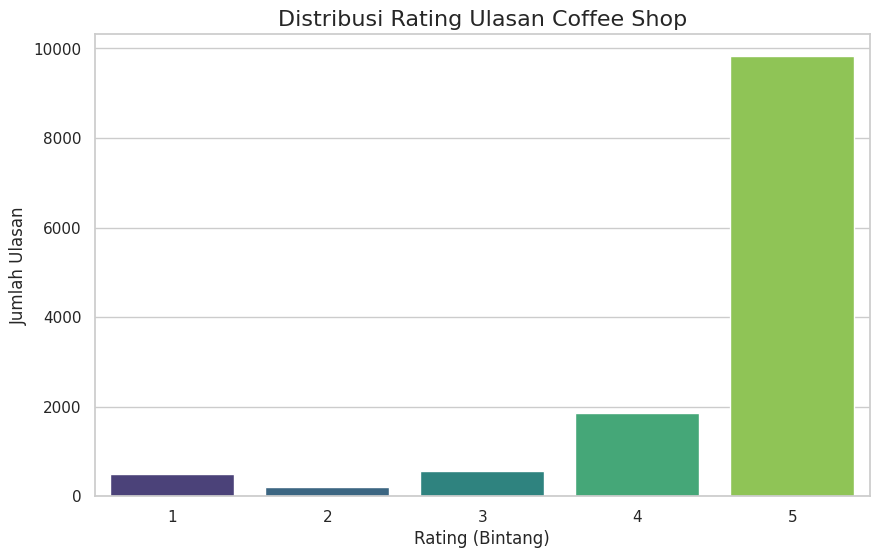


[Analisis] Distribusi Panjang Ulasan:


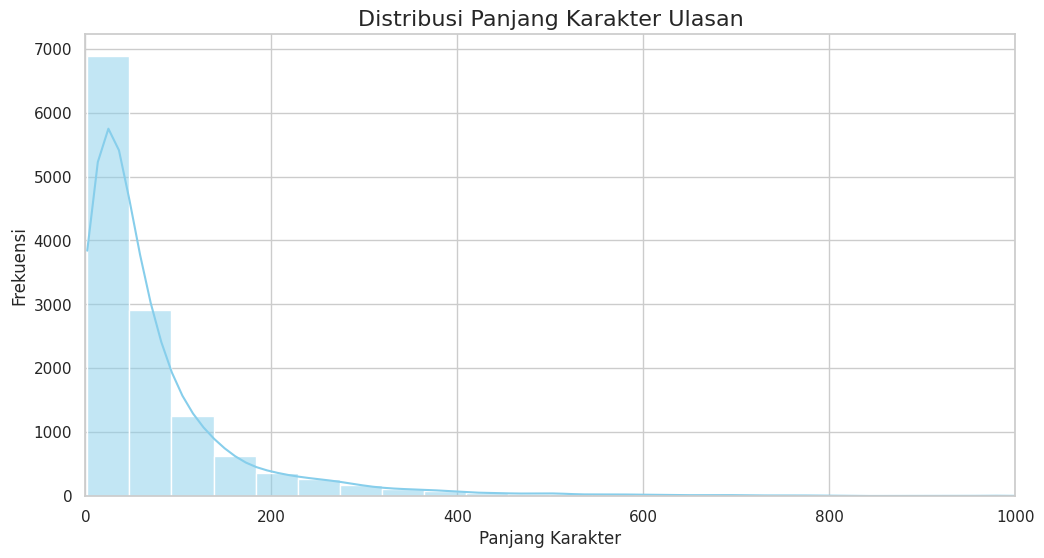


[Analisis] Jumlah Gambar per Coffee Shop:
Distribusi gambar per coffee shop (Top 10):
   Kelas (Coffee Shop)  Jumlah Gambar
9                CS038             68
49               CS001             66
35               CS002             65
6                CS033             50
42               CS005             47
24               CS020             45
20               CS035             45
30               CS034             43
36               CS050             41
31               CS008             41


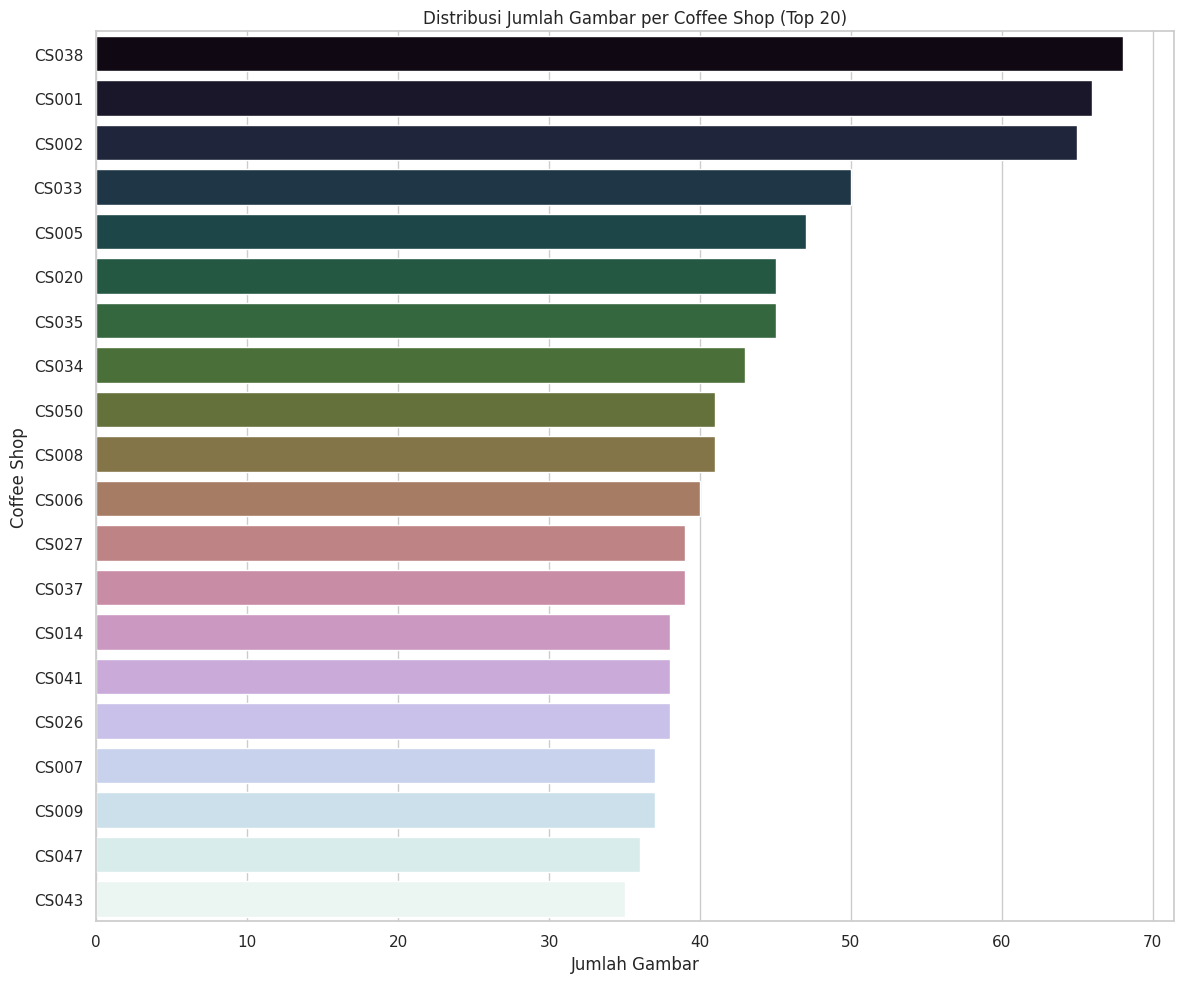

In [4]:
try:
    reviews_df = pd.read_csv(PATH_TO_REVIEWS_CSV)
    print("\nDataset berhasil dimuat.")
    print(f"Jumlah data: {len(reviews_df)}")
except FileNotFoundError:
    print("\nERROR: File 'reviews-text.csv' tidak ditemukan.")
    exit()

# --- Analisis Awal & Cleaning ---
print("\n[Analisis] Jumlah Data & Hasil Cleaning:")
initial_count = len(reviews_df)
print(f"Jumlah data keseluruhan (awal): {initial_count}")

# Hapus ulasan kosong
reviews_df.dropna(subset=['text'], inplace=True)
print(f"Jumlah data setelah menghapus ulasan kosong: {len(reviews_df)}")

# Hapus duplikat
reviews_df.drop_duplicates(inplace=True)
final_count = len(reviews_df)
print(f"Jumlah data bersih (setelah cleaning): {final_count}")
print(f"Total data yang dihapus: {initial_count - final_count}")

# --- Distribusi Rating ---
print("\n[Analisis] Distribusi Rating:")
plt.figure(figsize=(10, 6))
sns.countplot(x='stars', data=reviews_df, palette="viridis", order=sorted(reviews_df['stars'].unique()))
plt.title('Distribusi Rating Ulasan Coffee Shop', fontsize=16)
plt.xlabel('Rating (Bintang)', fontsize=12)
plt.ylabel('Jumlah Ulasan', fontsize=12)
plt.savefig(os.path.join(KAGGLE_OUTPUT_DIR, 'distribusi_rating.png'))
plt.show()

# --- Distribusi Panjang Ulasan ---
print("\n[Analisis] Distribusi Panjang Ulasan:")
reviews_df['text_length'] = reviews_df['text'].str.len()
plt.figure(figsize=(12, 6))
sns.histplot(reviews_df['text_length'], bins=50, kde=True, color='skyblue')
plt.title('Distribusi Panjang Karakter Ulasan', fontsize=16)
plt.xlabel('Panjang Karakter', fontsize=12)
plt.ylabel('Frekuensi', fontsize=12)
plt.xlim(0, 1000)
plt.savefig(os.path.join(KAGGLE_OUTPUT_DIR, 'distribusi_panjang_ulasan.png'))
plt.show()

# --- Jumlah Gambar per Coffee Shop ---
print("\n[Analisis] Jumlah Gambar per Coffee Shop:")
if os.path.isdir(ORIGINAL_IMAGE_DIR):
    class_folders = [f for f in os.listdir(ORIGINAL_IMAGE_DIR) if os.path.isdir(os.path.join(ORIGINAL_IMAGE_DIR, f))]
    image_counts = {folder: len(os.listdir(os.path.join(ORIGINAL_IMAGE_DIR, folder))) for folder in class_folders}
    image_dist_df = pd.DataFrame(list(image_counts.items()), columns=['Kelas (Coffee Shop)', 'Jumlah Gambar'])
    image_dist_df = image_dist_df.sort_values(by='Jumlah Gambar', ascending=False)
    print("Distribusi gambar per coffee shop (Top 10):")
    print(image_dist_df.head(10))

    plt.figure(figsize=(12, 10))
    sns.barplot(x='Jumlah Gambar', y='Kelas (Coffee Shop)', data=image_dist_df.head(20), palette="cubehelix")
    plt.title('Distribusi Jumlah Gambar per Coffee Shop (Top 20)')
    plt.xlabel('Jumlah Gambar')
    plt.ylabel('Coffee Shop')
    plt.tight_layout()
    plt.savefig(os.path.join(KAGGLE_OUTPUT_DIR, 'distribusi_gambar_per_kelas.png'))
    plt.show()
else:
    print(f"Peringatan: Direktori tidak ditemukan di '{ORIGINAL_IMAGE_DIR}'. Analisis gambar dilewati.")


[Analisis] Korelasi Panjang Ulasan vs. Rating (Heatmap):
             text_length     stars
text_length     1.000000 -0.206628
stars          -0.206628  1.000000


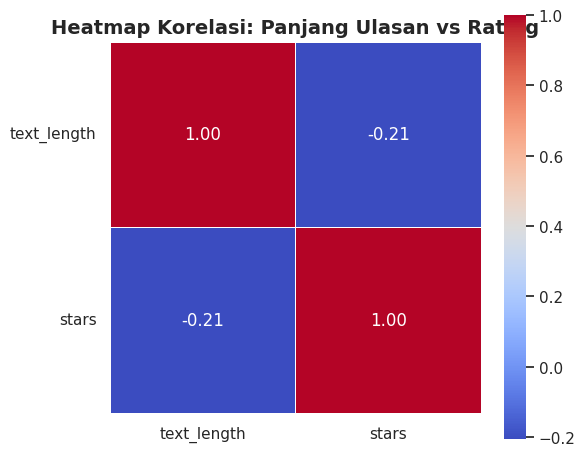

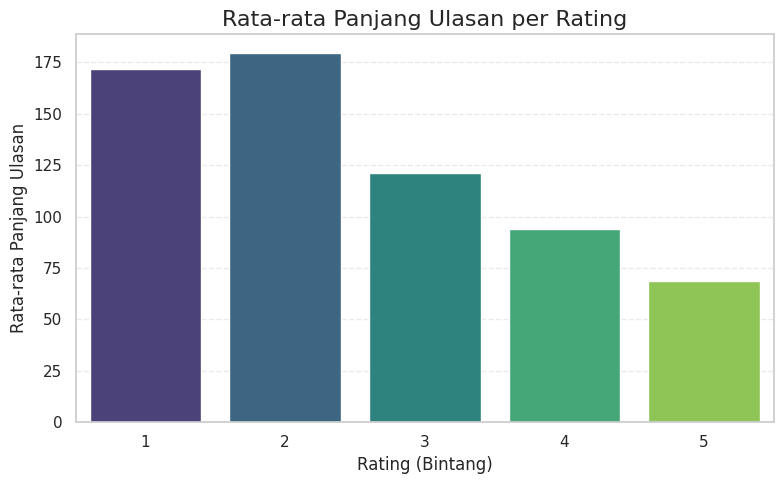

   stars  text_length
0      1   171.899384
1      2   179.566667
2      3   121.005263
3      4    93.967880
4      5    68.664767


In [5]:
# Hitung korelasi
corr_matrix = reviews_df[['text_length', 'stars']].corr()

# Tampilkan hasil korelasi di konsol
print("\n[Analisis] Korelasi Panjang Ulasan vs. Rating (Heatmap):")
print(corr_matrix)

# Visualisasi Heatmap
plt.figure(figsize=(6, 5))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", square=True, linewidths=0.5)
plt.title('Heatmap Korelasi: Panjang Ulasan vs Rating', fontsize=14, weight='bold')
plt.xticks(rotation=0)
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

plt.figure(figsize=(8, 5))
avg_length = reviews_df.groupby('stars')['text_length'].mean().reset_index()
sns.barplot(x='stars', y='text_length', data=avg_length, palette='viridis')
plt.title('Rata-rata Panjang Ulasan per Rating', fontsize=16)
plt.xlabel('Rating (Bintang)', fontsize=12)
plt.ylabel('Rata-rata Panjang Ulasan', fontsize=12)
plt.grid(True, axis='y', linestyle='--', alpha=0.4)
plt.tight_layout()
plt.show()

print(avg_length)

In [6]:
image_dir = ORIGINAL_IMAGE_DIR
image_data = []

for shop_id in os.listdir(image_dir):
    shop_path = os.path.join(image_dir, shop_id)
    if not os.path.isdir(shop_path):
        continue

    for img_file in os.listdir(shop_path):
        if not img_file.lower().endswith(('jpg', 'jpeg', 'png')):
            continue

        img_path = os.path.join(shop_path, img_file)
        try:
            with Image.open(img_path) as img:
                width, height = img.size
                aspect_ratio = width / height if height > 0 else None
                status = 'OK'
        except Exception:
            width, height, aspect_ratio = None, None, None
            status = 'Error'

        image_data.append({
            'id_shop': shop_id,
            'filename': img_file,
            'width': width,
            'height': height,
            'aspect_ratio': aspect_ratio,
            'status': status
        })

# Buat DataFrame-nya
import pandas as pd
image_df = pd.DataFrame(image_data)

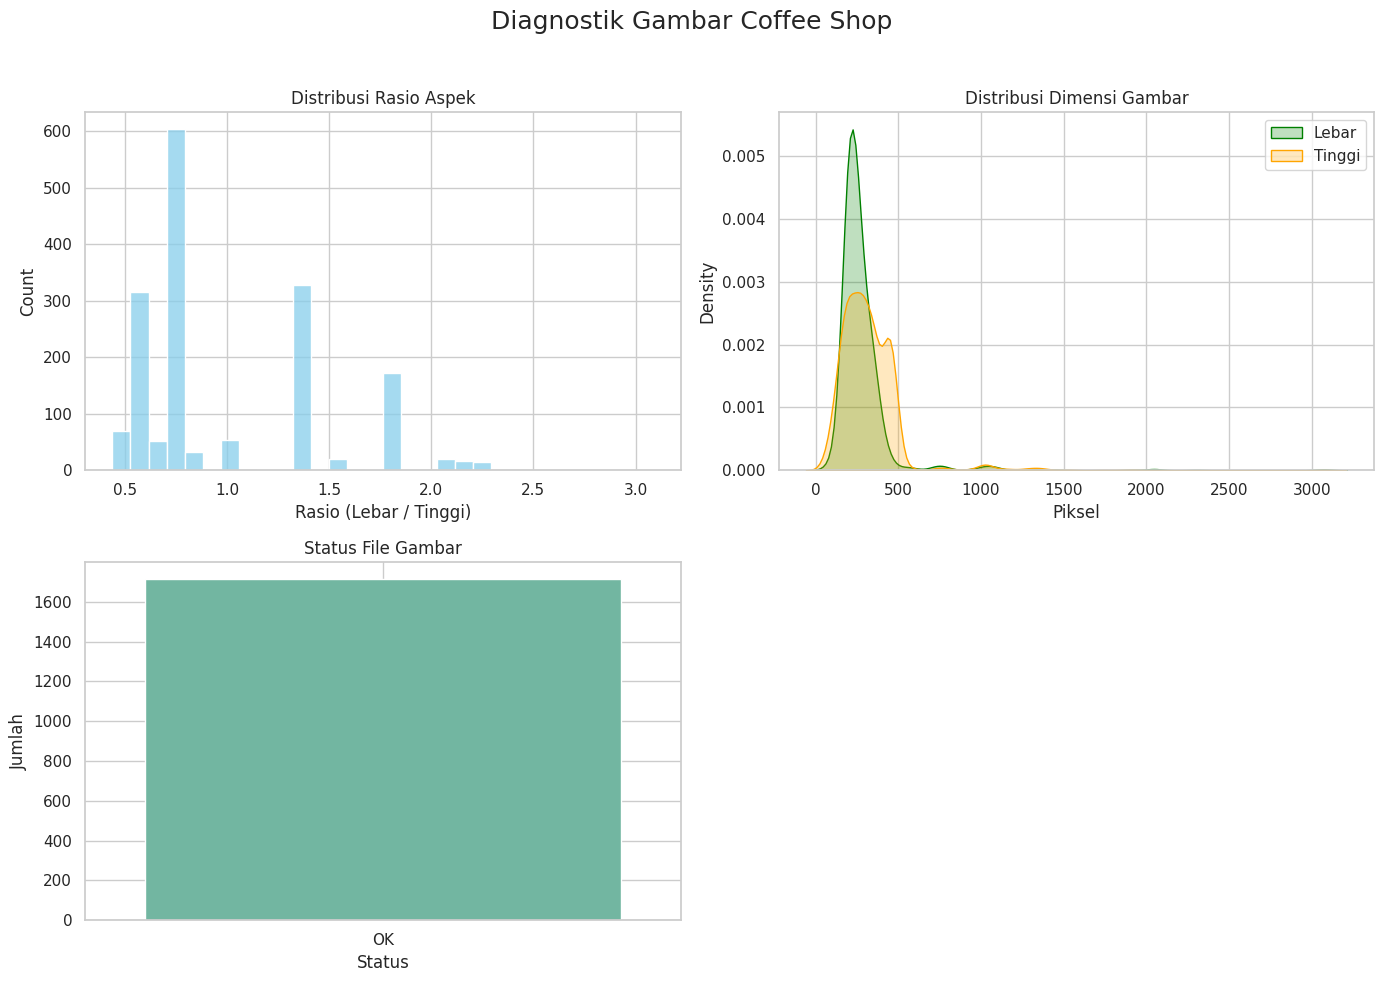


Ringkasan Statistik Rasio Aspek Gambar:
count    1713.000000
mean        0.983097
std         0.449652
min         0.439024
25%         0.667406
50%         0.749263
75%         1.333333
max         3.088083
Name: aspect_ratio, dtype: float64

Ringkasan Statistik Lebar Gambar:
count    1713.000000
mean      280.119089
std       208.086540
min        86.000000
25%       203.000000
50%       254.000000
75%       300.000000
max      3072.000000
Name: width, dtype: float64

Ringkasan Statistik Tinggi Gambar:
count    1713.000000
mean      321.643316
std       198.570809
min        76.000000
25%       194.000000
50%       271.000000
75%       398.000000
max      3072.000000
Name: height, dtype: float64
status
OK    1713
Name: count, dtype: int64


In [7]:
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
fig.suptitle('Diagnostik Gambar Coffee Shop', fontsize=18)

# Distribusi Rasio Aspek
sns.histplot(image_df['aspect_ratio'].dropna(), bins=30, color='skyblue', ax=axes[0, 0])
axes[0, 0].set_title('Distribusi Rasio Aspek')
axes[0, 0].set_xlabel('Rasio (Lebar / Tinggi)')
axes[0, 0].grid(True)

# Distribusi Lebar dan Tinggi Gambar
sns.kdeplot(image_df['width'].dropna(), label='Lebar', fill=True, color='green', ax=axes[0, 1])
sns.kdeplot(image_df['height'].dropna(), label='Tinggi', fill=True, color='orange', ax=axes[0, 1])
axes[0, 1].set_title('Distribusi Dimensi Gambar')
axes[0, 1].set_xlabel('Piksel')
axes[0, 1].legend()
axes[0, 1].grid(True)

# Jumlah Gambar Berdasarkan Status File
status_counts = image_df['status'].value_counts()
sns.barplot(x=status_counts.index, y=status_counts.values, palette='Set2', ax=axes[1, 0])
axes[1, 0].set_title('Status File Gambar')
axes[1, 0].set_xlabel('Status')
axes[1, 0].set_ylabel('Jumlah')
axes[1, 0].grid(True)

# Kosongkan plot keempat (jika hanya 3 grafik)
axes[1, 1].axis('off')

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

# Menyajikan ringkasan statistik untuk dicetak
print("\nRingkasan Statistik Rasio Aspek Gambar:")
print(image_df['aspect_ratio'].describe())

print("\nRingkasan Statistik Lebar Gambar:")
print(image_df['width'].describe())

print("\nRingkasan Statistik Tinggi Gambar:")
print(image_df['height'].describe())
print(status_counts)


[Analisis] Isi Ulasan untuk Rating Ekstrem (Bigram Word Cloud):


[nltk_data] Downloading package punkt to /usr/share/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt_tab to /usr/share/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


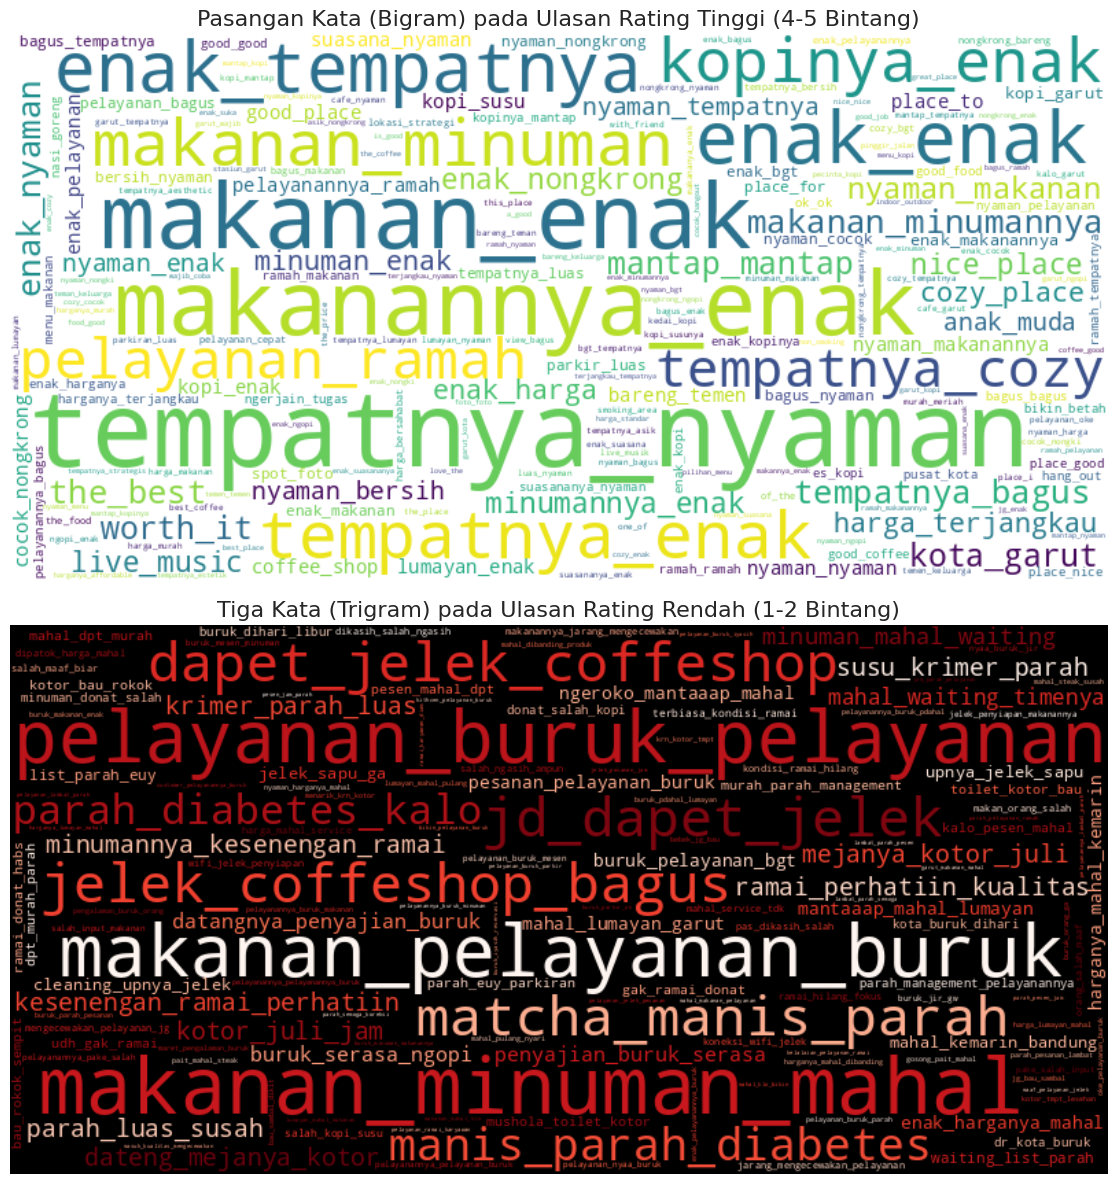

In [8]:
# --- Analisis Isi Ulasan terhadap Rating (Bigram Word Cloud) ---
print("\n[Analisis] Isi Ulasan untuk Rating Ekstrem (Bigram Word Cloud):")

# Pastikan library NLTK yang diperlukan sudah diunduh
try:
    import nltk
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('punkt_tab') # Download the missing resource
    from nltk.corpus import stopwords

    stopwords_id = stopwords.words('indonesian')
    # Tambahkan custom stopwords jika perlu
    custom_stopwords = ["yg", "aja", "sih", "nya", "banget", "y", "and", "di", "ke", "dari", "ini", "itu", "in"]
    stopwords_id.extend(custom_stopwords)
except Exception as e:
    print(f"Gagal mengunduh NLTK data: {e}")
    stopwords_id = []

# Import tambahan untuk tokenisasi
from nltk.tokenize import word_tokenize
from nltk import bigrams
from nltk import trigrams  # untuk trigram

kata_negatif = [
    "buruk", "jelek", "parah", "lama", "kotor", "mahal", "tidak", "kurang",
    "mengecewakan", "bau", "berisik", "pelan", "tidak_enak", "tidak_rekomendasi",
    "parah", "ramai", "tidak_bersih", "salah", "tidak_ada", "ga_worth_it"
]


# --- Fungsi untuk Bigram ---
def generate_bigram_text(text_corpus, stopwords_list):
    tokens = word_tokenize(text_corpus.lower())
    cleaned_tokens = [word for word in tokens if word.isalpha() and word not in stopwords_list]
    bigram_tuples = list(bigrams(cleaned_tokens))
    bigram_text = " ".join(["_".join(pair) for pair in bigram_tuples])
    return bigram_text

# --- Fungsi untuk Trigram ---
def generate_filtered_trigram_text(text_corpus, stopwords_list, kata_negatif):
    tokens = word_tokenize(text_corpus.lower())
    cleaned_tokens = [word for word in tokens if word.isalpha() and word not in stopwords_list]
    trigram_tuples = list(trigrams(cleaned_tokens))

    # Filter hanya trigram yang mengandung kata negatif
    filtered_trigrams = [
        trio for trio in trigram_tuples
        if any(neg_word in trio for neg_word in kata_negatif)
    ]

    trigram_text = " ".join(["_".join(trio) for trio in filtered_trigrams])
    return trigram_text


# --- Ambil Data Ulasan ---
# Pastikan reviews_df sudah ada dan memiliki kolom 'stars' dan 'text'
ulasan_rating_tinggi_corpus = ' '.join(reviews_df[reviews_df['stars'] >= 4]['text'].dropna())
ulasan_rating_rendah_corpus = ' '.join(reviews_df[reviews_df['stars'] <= 2]['text'].dropna())

# --- Proses Bigram & Trigram ---
bigram_text_tinggi = generate_bigram_text(ulasan_rating_tinggi_corpus, stopwords_id)
trigram_text_rendah = generate_filtered_trigram_text(
    ulasan_rating_rendah_corpus,
    stopwords_id,
    kata_negatif
)


# --- Generate WordCloud ---
wc_tinggi = WordCloud(width=800, height=400, background_color='white', collocations=False).generate(bigram_text_tinggi) \
    if bigram_text_tinggi else None

wc_rendah = WordCloud(width=800, height=400, background_color='black', colormap='Reds', collocations=False).generate(trigram_text_rendah) \
    if trigram_text_rendah else None

# --- Plotting ---
fig, axes = plt.subplots(2, 1, figsize=(15, 12))

# WordCloud Ulasan Tinggi (Bigram)
if wc_tinggi:
    axes[0].imshow(wc_tinggi, interpolation='bilinear')
    axes[0].set_title('Pasangan Kata (Bigram) pada Ulasan Rating Tinggi (4-5 Bintang)', fontsize=16)
    axes[0].axis('off')
else:
    axes[0].text(0.5, 0.5, 'Data tidak tersedia', horizontalalignment='center', verticalalignment='center', transform=axes[0].transAxes)
    axes[0].set_title('Pasangan Kata (Bigram) pada Ulasan Rating Tinggi (4-5 Bintang)', fontsize=16)
    axes[0].axis('off')

# WordCloud Ulasan Rendah (Trigram)
if wc_rendah:
    axes[1].imshow(wc_rendah, interpolation='bilinear')
    axes[1].set_title('Tiga Kata (Trigram) pada Ulasan Rating Rendah (1-2 Bintang)', fontsize=16)
    axes[1].axis('off')
else:
    axes[1].text(0.5, 0.5, 'Data tidak tersedia', horizontalalignment='center', verticalalignment='center', transform=axes[1].transAxes)
    axes[1].set_title('Tiga Kata (Trigram) pada Ulasan Rating Rendah (1-2 Bintang)', fontsize=16)
    axes[1].axis('off')

plt.tight_layout()
plt.show()

# Data Preprocessing

In [9]:
import shutil
# Hapus direktori lama jika ada untuk memastikan proses yang bersih
if os.path.exists(os.path.dirname(os.path.dirname(PROCESSED_IMAGE_DIR))):
    print("Menghapus direktori proses lama...")
    shutil.rmtree(os.path.dirname(os.path.dirname(PROCESSED_IMAGE_DIR)))

# Salin seluruh folder gambar dari input ke direktori kerja agar bisa dimodifikasi
print(f"Menyalin gambar dari '{ORIGINAL_IMAGE_DIR}' ke '{PROCESSED_IMAGE_DIR}'...")
shutil.copytree(ORIGINAL_IMAGE_DIR, PROCESSED_IMAGE_DIR)
print("Penyalinan selesai. Gambar sekarang siap untuk diproses.")


# Membuat struktur direktori untuk output preprocessing
print("\nLangkah 1: Membuat struktur direktori output...")
steps = {
    "images": ["original_copies", "resized", "augmented", "normalized_tensors", "normalized_displayable"],
    "text": ["original_copies", "cleaned", "tokenized", "encoded_tensors"]
}
for modality, substeps in steps.items():
    for step in substeps:
        os.makedirs(os.path.join(OUTPUT_BASE_DIR, modality, step), exist_ok=True)
print(f"Struktur direktori berhasil dibuat di: '{OUTPUT_BASE_DIR}'")

Menyalin gambar dari '/kaggle/input/coffee-shop-garut/Gambar/Gambar' ke '/kaggle/working/processed_images/Gambar/Gambar'...
Penyalinan selesai. Gambar sekarang siap untuk diproses.

Langkah 1: Membuat struktur direktori output...
Struktur direktori berhasil dibuat di: '/kaggle/working/full_preprocessing_output'


## Image Preprocessing

In [10]:
import random
# Fungsi augmentasi yang akan dijalankan pada direktori kerja
def augment_images_for_underrepresented_shops(image_base_path, threshold=20, target_count=30):
    augment_ops = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0),
        transforms.RandomRotation(15),
        transforms.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.3)
    ])
    shop_list = [d for d in os.listdir(image_base_path) if os.path.isdir(os.path.join(image_base_path, d))]
    for shop_id in tqdm(shop_list, desc="Augmentasi Gambar"):
        shop_path = os.path.join(image_base_path, shop_id)
        
        img_files = [f for f in os.listdir(shop_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        num_images = len(img_files)

        if num_images >= threshold or not img_files:
            continue

        needed = target_count - num_images
        i = 0
        while i < needed:
            img_file = random.choice(img_files)
            img_path = os.path.join(shop_path, img_file)
            try:
                image = Image.open(img_path).convert('RGB')
                aug_image = augment_ops(image)
                new_filename = f"aug_{i}_{img_file}"
                aug_image.save(os.path.join(shop_path, new_filename))
                i += 1
            except Exception as e:
                print(f"[ERROR] Gagal augmentasi {img_file}: {e}")
    print("Augmentasi selesai.")

# Jalankan augmentasi pada direktori yang baru (di /kaggle/working/)
augment_images_for_underrepresented_shops(PROCESSED_IMAGE_DIR)

# Definisi model dan transformasi
resnet_model = models.resnet18(pretrained=True)
resnet_model = nn.Sequential(*list(resnet_model.children())[:-1])  # Remove FC layer
resnet_model.to(device).eval()

resize_op = transforms.Resize((224, 224))
augment_ops = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(15),
    transforms.ColorJitter(brightness=0.3, contrast=0.3)
])
normalization_ops = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

to_pil_image = transforms.ToPILImage()

Augmentasi Gambar: 100%|██████████| 53/53 [00:01<00:00, 52.78it/s]


Augmentasi selesai.
Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to /root/.cache/torch/hub/checkpoints/resnet18-f37072fd.pth


100%|██████████| 44.7M/44.7M [00:00<00:00, 169MB/s] 


In [11]:
def process_and_save_image_steps(original_image_path, output_dir, unique_id):
    try:
        img = Image.open(original_image_path).convert('RGB')
        # Tahap 1: Simpan salinan asli
        img.save(os.path.join(output_dir, "images/original_copies", f"{unique_id}.jpg"))
        # Tahap 2: Resize
        resized_img = resize_op(img)
        resized_img.save(os.path.join(output_dir, "images/resized", f"{unique_id}.jpg"))
        # Tahap 3: Augmentasi
        augmented_img = augment_ops(resized_img)
        augmented_img.save(os.path.join(output_dir, "images/augmented", f"{unique_id}.jpg"))
        # Tahap 4: Normalisasi & konversi ke Tensor
        normalized_tensor = normalization_ops(resized_img)
        torch.save(normalized_tensor, os.path.join(output_dir, "images/normalized_tensors", f"{unique_id}.pt"))

        displayable_img = to_pil_image(normalized_tensor)
        displayable_img.save(os.path.join(output_dir, "images/normalized_displayable", f"{unique_id}.jpg"))
    except Exception as e:
        print(f"Gagal memproses gambar {original_image_path}: {e}")
print("Fungsi 'process_and_save_image_steps' telah diperbarui.")

Fungsi 'process_and_save_image_steps' telah diperbarui.


## Text Preprocessing

In [12]:
## Teks Preprocessing
stopword_id = set(stopwords.words('indonesian'))
custom_stopwords = ["yg", "aja", "sih", "nya", "banget", "y", "and", "di", "ke", "dari", "ini", "itu", "in"]
stopword_id.update(custom_stopwords)

def clean_text(text):
    if not isinstance(text, str) or text.strip() == "": return ""
    text = text.lower()
    text = re.sub(r'https://\S+|www\.\S+', '', text)
    text = re.sub(r'<.*?>', '', text)
    text = re.sub(r'[^a-z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    tokens = word_tokenize(text)
    filtered_tokens = [word for word in tokens if word not in stopword_id]
    return ' '.join(filtered_tokens)

# bert_tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bert_model = BertModel.from_pretrained('bert-base-uncased')
bert_tokenizer = BertTokenizer.from_pretrained('bert-base-multilingual-cased')
bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')
bert_model.to(device).eval()

def process_and_save_text_steps(review_data, output_dir):
    try:
        unique_id = review_data.name
        original_text = review_data['text'] if isinstance(review_data['text'], str) else ""
        with open(os.path.join(output_dir, "text/original_copies", f"review_{unique_id}.txt"), "w", encoding='utf-8') as f: f.write(original_text)
        cleaned_text = clean_text(original_text)
        with open(os.path.join(output_dir, "text/cleaned", f"review_{unique_id}.txt"), "w", encoding='utf-8') as f: f.write(cleaned_text)
        tokens = word_tokenize(cleaned_text)
        with open(os.path.join(output_dir, "text/tokenized", f"review_{unique_id}.txt"), "w", encoding='utf-8') as f: f.write("\n".join(tokens))
        encoded = bert_tokenizer(cleaned_text, padding='max_length', truncation=True, max_length=128, return_tensors='pt')
        torch.save(encoded, os.path.join(output_dir, "text/encoded_tensors", f"review_{unique_id}.pt"))
    except Exception as e:
        print(f"Gagal memproses teks untuk review index {review_data.name}: {e}")
print("Fungsi 'process_and_save_text_steps' siap digunakan.")

tokenizer_config.json:   0%|          | 0.00/49.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.96M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/625 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/714M [00:00<?, ?B/s]

Fungsi 'process_and_save_text_steps' siap digunakan.



Langkah 4: Menjalankan proses pada data Anda...
Berhasil memuat 13636 ulasan.
Pembersihan teks pada dataframe selesai.


Memproses Data: 100%|██████████| 13636/13636 [02:40<00:00, 84.87it/s]




✅ Proses selesai. Semua hasil preprocessing tersimpan di folder '/kaggle/working/full_preprocessing_output'.

Memulai proses visualisasi perbandingan preprocessing...
🖼️ 1. PREPROCESSING GAMBAR: SEBELUM vs. SESUDAH

[Analisis] Jumlah gambar setelah augmentasi...


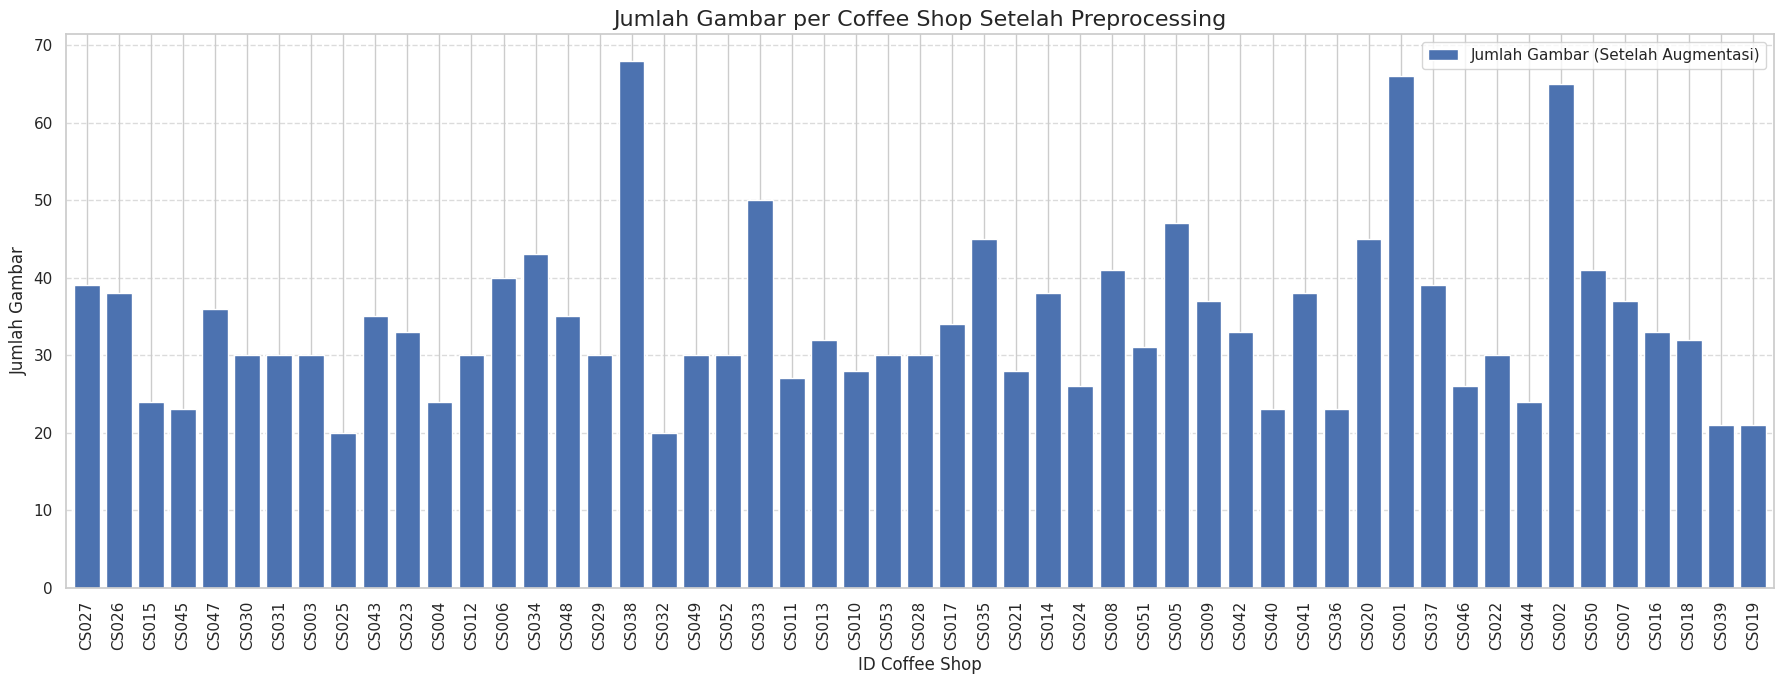


[Visualisasi] Menampilkan contoh gambar sebelum dan sesudah preprocessing...


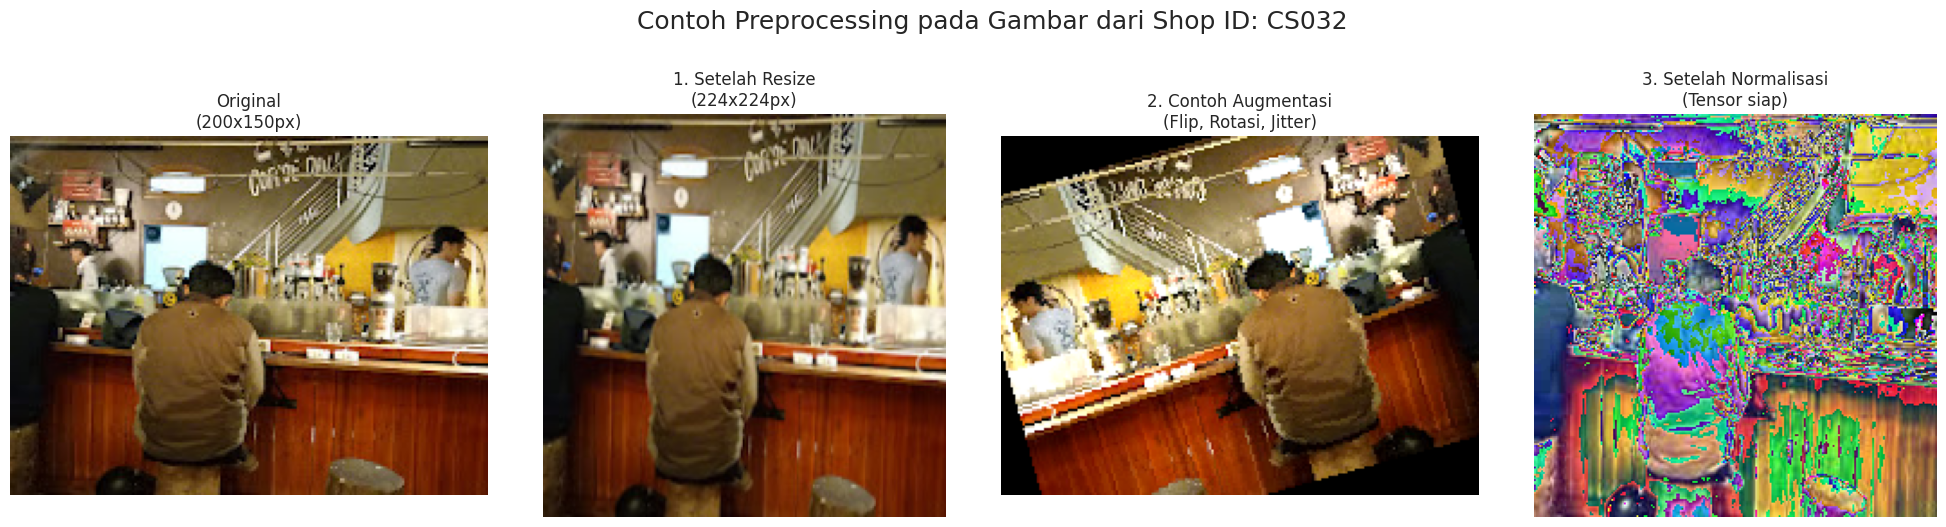


📝 2. PREPROCESSING TEKS ULASAN: SEBELUM vs. SESUDAH

✨ **1. Pembersihan Teks**
------------------------------
**SEBELUM:**
'Bagi kalian para pecinta kopi, cobalah untuk singgah di Koffie Talkie, tempat ini nyaman untuk dipakai berbincang dengan kawan lama, atau digunakan rapat dan diskusi. Fasilitas yang disuguhkan cukup memanjakan konsumen, belum lagi olahan kopi nya yang bervariasi jenis, diracik dan diolah oleh profesional menghasilkan kopi yang nikmat....
Coba dulu deh.....'

**SESUDAH (lowercase, no-punctuation, no-stopwords):**
'pecinta kopi cobalah singgah koffie talkie nyaman dipakai berbincang kawan rapat diskusi fasilitas disuguhkan memanjakan konsumen olahan kopi bervariasi jenis diracik diolah profesional menghasilkan kopi nikmat coba deh'

✨ **2. Tokenisasi**
------------------------------
**SESUDAH (Menjadi daftar Token):**
['pe', '##cinta', 'kopi', 'co', '##bala', '##h', 'sing', '##gah', 'ko', '##ffi', '##e', 'talk', '##ie', 'nya', '##man', 'dipakai', 'be', '##rb', '##i

In [13]:
print("\nLangkah 4: Menjalankan proses pada data Anda...")
try:
    reviews_df = pd.read_csv(PATH_TO_REVIEWS_CSV)
    print(f"Berhasil memuat {len(reviews_df)} ulasan.")
    reviews_df['cleaned_text'] = reviews_df['text'].apply(clean_text)
    print("Pembersihan teks pada dataframe selesai.")

    for index, row in tqdm(reviews_df.iterrows(), total=len(reviews_df), desc="Memproses Data"):
        process_and_save_text_steps(row, OUTPUT_BASE_DIR)
        shop_id = str(row['id_shop'])
        # Gunakan path yang sudah diproses
        shop_path = os.path.join(PROCESSED_IMAGE_DIR, shop_id)
        if os.path.isdir(shop_path):
            images = [f for f in os.listdir(shop_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
            if images:
                img_name = random.choice(images)
                img_path = os.path.join(shop_path, img_name)
                img_unique_id = f"{shop_id}_{os.path.splitext(img_name)[0]}"
                process_and_save_image_steps(img_path, OUTPUT_BASE_DIR, img_unique_id)
except FileNotFoundError:
    print(f"\n[PERINGATAN] File CSV '{PATH_TO_REVIEWS_CSV}' tidak ditemukan.")
    print("Proses eksekusi utama dilewati.")

print(f"\n\n✅ Proses selesai. Semua hasil preprocessing tersimpan di folder '{OUTPUT_BASE_DIR}'.")

# --- Definisi Fungsi Visualisasi ---
def hitung_jumlah_gambar(base_path):
    image_counts = {}
    if not os.path.isdir(base_path):
        print(f"Direktori tidak ditemukan: {base_path}")
        return pd.Series(dtype=int)
    for shop_id in os.listdir(base_path):
        shop_path = os.path.join(base_path, shop_id)
        if os.path.isdir(shop_path):
            num_images = len([f for f in os.listdir(shop_path) if f.lower().endswith(('jpg', 'jpeg', 'png'))])
            image_counts[shop_id] = num_images
    return pd.Series(image_counts)

def tampilkan_perbandingan_gambar(image_base_path, augment_func, image_transform_pipeline):
    print("="*60)
    print("🖼️ 1. PREPROCESSING GAMBAR: SEBELUM vs. SESUDAH")
    print("="*60)
    print("\n[Analisis] Jumlah gambar setelah augmentasi...")
    counts_after_augmentation = hitung_jumlah_gambar(image_base_path)
    comparison_df = pd.DataFrame({'Jumlah Gambar (Setelah Augmentasi)': counts_after_augmentation}).fillna(0).astype(int)
    comparison_df.plot(kind='bar', figsize=(18, 7), width=0.8)
    plt.title('Jumlah Gambar per Coffee Shop Setelah Preprocessing', fontsize=16)
    plt.ylabel('Jumlah Gambar', fontsize=12)
    plt.xlabel('ID Coffee Shop', fontsize=12)
    plt.xticks(rotation=90)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    print("\n[Visualisasi] Menampilkan contoh gambar sebelum dan sesudah preprocessing...")
    non_empty_shops = [sid for sid, count in counts_after_augmentation.items() if count > 0]
    if not non_empty_shops:
        print("Tidak ada shop dengan gambar untuk ditampilkan.")
        return

    random_shop_id = random.choice(non_empty_shops)
    shop_path = os.path.join(image_base_path, random_shop_id)
    # Cari gambar asli (bukan hasil augmentasi) untuk perbandingan
    original_images = [f for f in os.listdir(shop_path) if not f.startswith('aug_') and f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if not original_images:
        print(f"Tidak ada gambar original di shop {random_shop_id} untuk perbandingan.")
        return

    random_image_name = random.choice(original_images)
    image_path = os.path.join(shop_path, random_image_name)
    original_img = Image.open(image_path).convert('RGB')
    resized_img = transforms.Resize((224, 224))(original_img)
    augmented_img = transforms.Compose([
        transforms.RandomHorizontalFlip(p=1.0), transforms.RandomRotation(20),
        transforms.ColorJitter(brightness=0.4, contrast=0.4)
    ])(original_img)
    normalized_tensor = image_transform_pipeline(original_img)
    # Perlu ToPILImage untuk display, pastikan didefinisikan
    if 'to_pil_image' not in globals():
        globals()['to_pil_image'] = transforms.ToPILImage()
    normalized_img_for_display = to_pil_image(normalized_tensor)

    fig, axes = plt.subplots(1, 4, figsize=(20, 5))
    fig.suptitle(f'Contoh Preprocessing pada Gambar dari Shop ID: {random_shop_id}', fontsize=18, y=1.05)
    axes[0].imshow(original_img); axes[0].set_title(f'Original\n({original_img.width}x{original_img.height}px)'); axes[0].axis('off')
    axes[1].imshow(resized_img); axes[1].set_title('1. Setelah Resize\n(224x224px)'); axes[1].axis('off')
    axes[2].imshow(augmented_img); axes[2].set_title('2. Contoh Augmentasi\n(Flip, Rotasi, Jitter)'); axes[2].axis('off')
    axes[3].imshow(normalized_img_for_display); axes[3].set_title('3. Setelah Normalisasi\n(Tensor siap)'); axes[3].axis('off')
    plt.tight_layout()
    plt.show()

def tampilkan_perbandingan_teks(reviews_dataframe, clean_func, tokenizer, max_len=128):
    print("\n" + "="*60)
    print("📝 2. PREPROCESSING TEKS ULASAN: SEBELUM vs. SESUDAH")
    print("="*60)
    sample_review = reviews_dataframe[reviews_dataframe['text'].str.len() > 150].sample(1)['text'].iloc[0]
    print(f"\n✨ **1. Pembersihan Teks**"); print("-" * 30)
    print(f"**SEBELUM:**\n'{sample_review}'")
    cleaned_text = clean_func(sample_review)
    print(f"\n**SESUDAH (lowercase, no-punctuation, no-stopwords):**\n'{cleaned_text}'")
    print(f"\n✨ **2. Tokenisasi**"); print("-" * 30)
    tokens = tokenizer.tokenize(cleaned_text)
    print(f"**SESUDAH (Menjadi daftar Token):**\n{tokens}\nJumlah token: {len(tokens)}")
    print(f"\n✨ **3. Truncated Teks (Max Length: {max_len})**"); print("-" * 30)
    encoded = tokenizer(cleaned_text, padding='max_length', truncation=True, max_length=max_len)
    final_tokens = tokenizer.convert_ids_to_tokens(encoded['input_ids'])
    print(f"**SESUDAH (Token akhir untuk model BERT):**\n{final_tokens}\nJumlah token akhir: {len(final_tokens)}")

# Jalankan visualisasi
print("\nMemulai proses visualisasi perbandingan preprocessing...")

# Panggil fungsi visualisasi untuk gambar, arahkan ke direktori kerja yang sudah diproses
tampilkan_perbandingan_gambar(
    image_base_path=PROCESSED_IMAGE_DIR,
    augment_func=augment_images_for_underrepresented_shops,
    image_transform_pipeline=normalization_ops  # Memperbaiki variabel yang tidak terdefinisi
)

# Panggil fungsi visualisasi untuk teks
tampilkan_perbandingan_teks(
    reviews_dataframe=reviews_df,
    clean_func=clean_text,
    tokenizer=bert_tokenizer,
    max_len=128
)

print("\nProses visualisasi selesai.")

## Feature Extraction

In [14]:
# ==============================================================================
# 1. FUNGSI EKSTRAKSI FITUR (Tidak ada perubahan pada definisi fungsi)
# ==============================================================================
import time

def extract_visual_features(shop_id, image_base_path):
    """Mengekstrak fitur visual rata-rata dari semua gambar untuk satu coffee shop."""
    start_time = time.time()
    shop_folder = os.path.join(image_base_path, str(shop_id)) # Konversi shop_id ke string untuk keamanan

    if not os.path.exists(shop_folder):
        # Mengurangi output log agar tidak terlalu ramai
        # print(f"[SKIP] Folder tidak ditemukan untuk shop_id: {shop_id}")
        return None

    img_files = [f for f in os.listdir(shop_folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
    if not img_files:
        return None

    features = []
    for img_file in img_files:
        img_path = os.path.join(shop_folder, img_file)
        try:
            image = Image.open(img_path).convert('RGB')
            # Pastikan transformasi dan model sudah ada di 'device' yang benar
            image_tensor = normalization_ops(image).unsqueeze(0).to(device)

            with torch.no_grad():
                feature = resnet_model(image_tensor).squeeze()
            features.append(feature.cpu())
        except Exception as e:
            print(f"\n[PERINGATAN] Gagal ekstrak fitur dari {img_file}: {e}")
            continue

    if not features:
        # print(f"[ERROR] Tidak ada fitur valid untuk shop_id: {shop_id}")
        return None

    # Mengembalikan rata-rata fitur dari semua gambar
    result = torch.stack(features).mean(dim=0)
    # print(f"[DONE] Ekstraksi selesai untuk shop_id: {shop_id} - waktu: {time.time() - start_time:.2f}s")
    return result

def extract_textual_features(text, max_length=128):
    """Mengekstrak fitur teks dari ulasan menggunakan BERT."""
    try:
        encoded = bert_tokenizer(text, padding='max_length', truncation=True, max_length=max_length, return_tensors='pt')
        input_ids = encoded['input_ids'].to(device)
        attention_mask = encoded['attention_mask'].to(device)

        with torch.no_grad():
            output = bert_model(input_ids, attention_mask=attention_mask)
            cls_embedding = output.last_hidden_state[:, 0, :]  # Ambil embedding dari token [CLS]
        return cls_embedding.squeeze(0).cpu()
    except Exception as e:
        print(f"\n[PERINGATAN] Gagal ekstraksi fitur teks: {e}")
        return None


# ==============================================================================
# 2. PROSES EKSTRAKSI FITUR DAN PEMBUATAN CACHE
# ==============================================================================
print("Memulai proses ekstraksi fitur untuk semua data...")

# Cache untuk menyimpan fitur yang sudah diekstrak agar tidak perlu diulang
feature_cache = {}
shop_ids = reviews_df['id_shop'].unique()
first_feature_printed = False

for shop_id in tqdm(shop_ids, desc="Ekstraksi Fitur"):
    # === PERUBAHAN UTAMA DI SINI ===
    # Menggunakan path direktori kerja Kaggle (PROCESSED_IMAGE_DIR)
    # bukan path '/content/' dari Colab.
    img_feat = extract_visual_features(shop_id, PROCESSED_IMAGE_DIR)
    
    if img_feat is None:
        continue

    # Ambil semua ulasan yang berhubungan dengan coffee shop ini
    shop_reviews = reviews_df[reviews_df['id_shop'] == shop_id]
    for index, row in shop_reviews.iterrows():
        # Ekstrak fitur teks dari kolom 'cleaned_text'
        text_feat = extract_textual_features(row['cleaned_text'])
        if text_feat is None:
            continue

        # Simpan fitur ke dalam cache dengan kunci unik
        feature_cache[f"{shop_id}_{index}"] = {
            'text_features': text_feat,
            'image_features': img_feat,  # Fitur gambar sama untuk semua ulasan di satu shop
            'rating': row['stars']
        }

        if not first_feature_printed:
            print("\n\n" + "="*60)
            print("SAMPLE OUTPUT: Contoh Hasil Ekstraksi Fitur (Data Pertama)")
            print("="*60)
            
            # Tampilkan info fitur teks
            print(f"⭐ Fitur Teks (dari ulasan ID: {index})")
            print(f"   - Shape Tensor: {text_feat.shape}")
            print(f"   - Nilai 5 Elemen Pertama: {text_feat[:5].numpy()}")
            
            # Tampilkan info fitur gambar
            print(f"\n⭐ Fitur Gambar (dari coffee shop ID: {shop_id})")
            print(f"   - Shape Tensor: {img_feat.shape}")
            print(f"   - Nilai 5 Elemen Pertama: {img_feat[:5].numpy()}")
            print("="*60 + "\n")
            
            # Set flag menjadi True agar tidak mencetak lagi
            first_feature_printed = True

print(f"\n✅ Ekstraksi fitur selesai. Total sampel dalam cache: {len(feature_cache)}")

output_feature_path = os.path.join(KAGGLE_OUTPUT_DIR, "extracted_features.pth")

# 2. Simpan dictionary 'feature_cache' ke dalam file
print(f"\n💾 Menyimpan hasil ekstraksi fitur ke: {output_feature_path}...")
try:
    torch.save(feature_cache, output_feature_path)
    print("👍 Berhasil! File fitur telah disimpan.")
except Exception as e:
    print(f"❌ Gagal menyimpan file fitur: {e}")

Memulai proses ekstraksi fitur untuk semua data...


Ekstraksi Fitur:   0%|          | 0/52 [00:00<?, ?it/s]



SAMPLE OUTPUT: Contoh Hasil Ekstraksi Fitur (Data Pertama)
⭐ Fitur Teks (dari ulasan ID: 0)
   - Shape Tensor: torch.Size([768])
   - Nilai 5 Elemen Pertama: [ 0.05893549 -0.32154515  0.2931764   0.02429174  0.2574111 ]

⭐ Fitur Gambar (dari coffee shop ID: CS001)
   - Shape Tensor: torch.Size([512])
   - Nilai 5 Elemen Pertama: [0.67070824 0.89351887 1.7274036  0.37360886 0.40429625]



Ekstraksi Fitur: 100%|██████████| 52/52 [02:33<00:00,  2.96s/it]



✅ Ekstraksi fitur selesai. Total sampel dalam cache: 13636

💾 Menyimpan hasil ekstraksi fitur ke: /kaggle/working/extracted_features.pth...
👍 Berhasil! File fitur telah disimpan.


## Feature Engineering

In [15]:
class NCFDataset(Dataset):
    def __init__(self, reviews_df, image_base_path, text_tokenizer, image_transformer):
        self.reviews = reviews_df.to_dict('records')
        self.image_base_path = image_base_path
        self.text_tokenizer = text_tokenizer
        self.image_transformer = image_transformer

        # Cache path gambar untuk setiap coffee shop agar lebih cepat
        self.shop_image_paths = {}
        all_shop_ids = reviews_df['id_shop'].unique()
        for shop_id in all_shop_ids:
            # Menggunakan str(shop_id) untuk memastikan kompatibilitas path
            shop_folder = os.path.join(self.image_base_path, str(shop_id))
            if os.path.exists(shop_folder):
                self.shop_image_paths[shop_id] = [os.path.join(shop_folder, f)
                                                  for f in os.listdir(shop_folder)
                                                  if f.lower().endswith(('jpg', 'jpeg', 'png'))]
            else:
                self.shop_image_paths[shop_id] = []

    def __len__(self):
        return len(self.reviews)

    def __getitem__(self, idx):
        review_item = self.reviews[idx]
        text = review_item.get('cleaned_text', '') # Menggunakan teks yang sudah dibersihkan
        shop_id = review_item['id_shop']
        rating = torch.tensor(review_item['stars'], dtype=torch.float32)

        # --- Proses Teks (on-the-fly) ---
        text_encoding = self.text_tokenizer(
            text,
            padding='max_length',
            truncation=True,
            max_length=128,
            return_tensors='pt'
        )

        # --- Proses Gambar (on-the-fly) ---
        image_paths = self.shop_image_paths.get(shop_id, [])
        if image_paths:
            image_path = random.choice(image_paths)
            try:
                image = Image.open(image_path).convert('RGB')
                # Optimisasi: Langsung gunakan image_transformer utama
                # yang seharusnya sudah termasuk resize.
                image_tensor = self.image_transformer(image)
            except Exception:
                # Jika gambar rusak, gunakan tensor nol
                image_tensor = torch.zeros((3, 224, 224))
        else:
            # Jika tidak ada gambar, gunakan tensor nol
            image_tensor = torch.zeros((3, 224, 224))

        return {
            'input_ids': text_encoding['input_ids'].flatten(),
            'attention_mask': text_encoding['attention_mask'].flatten(),
            'image': image_tensor,
            'rating': rating
        }

## Split data

In [16]:
# ==============================================================================
# 1. MEMBAGI DATA DAN MEMBUAT DATASET
# ==============================================================================
from torch.utils.data.sampler import WeightedRandomSampler
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split


print("Membagi data menjadi training dan testing set (90:10) dengan stratifikasi...")
# Stratifikasi memastikan proporsi rating di training dan testing set sama dengan distribusi aslinya.
# Ini penting agar testing set dapat merepresentasikan kondisi data dunia nyata.
train_reviews, test_reviews = train_test_split(
    reviews_df,
    test_size=0.1,
    random_state=42,
    stratify=reviews_df['stars']
)

# --- Membuat Instance Dataset ---
# Pastikan kelas NCFDataset dan variabel lain seperti (bert_tokenizer, normalization_ops, PROCESSED_IMAGE_DIR)
# sudah didefinisikan sebelumnya di kode Anda.
print("Membuat instance dataset untuk training dan testing...")
image_dir = PROCESSED_IMAGE_DIR # Gunakan path yang benar
train_dataset = NCFDataset(train_reviews, image_dir, bert_tokenizer, normalization_ops)
test_dataset = NCFDataset(test_reviews, image_dir, bert_tokenizer, normalization_ops)


# ==============================================================================
# 2. MENGATASI DATA TIDAK SEIMBANG DENGAN WEIGHTED SAMPLING
# ==============================================================================

print("\nMenerapkan WeightedRandomSampler untuk menangani data tidak seimbang...")

# Hitung jumlah sampel untuk setiap kelas rating di data training
class_counts = train_reviews['stars'].value_counts().sort_index()
print("\nDistribusi kelas pada data training:")
print(class_counts)

# Tentukan target sampling: bobot dihitung berdasarkan '1 / frekuensi kelas'
num_samples = len(train_reviews)
max_weight = 5.0

class_weights = {
    cls: min(num_samples / count, max_weight)
    for cls, count in class_counts.items()
}
print(f"\nBobot kelas yang dihitung (dibatasi maks {max_weight}):")
# Tampilan bobot yang lebih rapi
for star, weight in class_weights.items():
    print(f"  Rating {star}: {weight:.2f}")


sample_weights = [class_weights[star] for star in train_reviews['stars']]

sampler = WeightedRandomSampler(
    weights=sample_weights,
    num_samples=len(sample_weights),
    replacement=True
)

# --- Langkah 4: Membuat DataLoader ---
BATCH_SIZE = 32

train_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    sampler=sampler,
    drop_last=True # Disarankan untuk stabilitas training
)

test_loader = DataLoader(
    test_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # Tidak perlu diacak untuk evaluasi
    drop_last=True
)

print(f"\nJumlah data training: {len(train_dataset)}")
print(f"Jumlah data testing: {len(test_dataset)}")
print(f"Ukuran batch: {BATCH_SIZE}")
print("\n✅ DataLoader dengan WeightedRandomSampler (sampling cerdas) siap digunakan.")

Membagi data menjadi training dan testing set (90:10) dengan stratifikasi...
Membuat instance dataset untuk training dan testing...

Menerapkan WeightedRandomSampler untuk menangani data tidak seimbang...

Distribusi kelas pada data training:
stars
1     456
2     200
3     555
4    1827
5    9234
Name: count, dtype: int64

Bobot kelas yang dihitung (dibatasi maks 5.0):
  Rating 1: 5.00
  Rating 2: 5.00
  Rating 3: 5.00
  Rating 4: 5.00
  Rating 5: 1.33

Jumlah data training: 12272
Jumlah data testing: 1364
Ukuran batch: 32

✅ DataLoader dengan WeightedRandomSampler (sampling cerdas) siap digunakan.


In [17]:
train_dataset_sample = NCFDataset(train_reviews, PROCESSED_IMAGE_DIR, bert_tokenizer, normalization_ops)

# Pastikan dataset tidak kosong
if len(train_dataset_sample) > 0:
    # Ambil output dari sampel data pertama (indeks 0)
    sample_output = train_dataset_sample[0]

    # Tampilkan hasilnya
    print("\n" + "="*50)
    print("CONTOH OUTPUT DARI NCFDataset (untuk 1 sampel data)")
    print("="*50)

    # Iterasi melalui dictionary dan cetak informasi setiap item
    for key, value in sample_output.items():
        print(f"\nKunci: '{key}'")
        print(f"  - Tipe Data: {type(value)}")
        if isinstance(value, torch.Tensor):
            print(f"  - Shape Tensor: {value.shape}")
            print(f"  - Tipe Elemen: {value.dtype}")
    print("\n" + "="*50)

else:
    print("Dataset training kosong, tidak bisa menampilkan sampel.")


CONTOH OUTPUT DARI NCFDataset (untuk 1 sampel data)

Kunci: 'input_ids'
  - Tipe Data: <class 'torch.Tensor'>
  - Shape Tensor: torch.Size([128])
  - Tipe Elemen: torch.int64

Kunci: 'attention_mask'
  - Tipe Data: <class 'torch.Tensor'>
  - Shape Tensor: torch.Size([128])
  - Tipe Elemen: torch.int64

Kunci: 'image'
  - Tipe Data: <class 'torch.Tensor'>
  - Shape Tensor: torch.Size([3, 224, 224])
  - Tipe Elemen: torch.float32

Kunci: 'rating'
  - Tipe Data: <class 'torch.Tensor'>
  - Shape Tensor: torch.Size([])
  - Tipe Elemen: torch.float32



# Train model and Evaluation

In [18]:
import torch.nn.functional as F

class Attention(nn.Module):
    """Implementasi sederhana dari Self-Attention Layer."""
    def __init__(self, feature_dim):
        super(Attention, self).__init__()
        # Lapisan untuk menghitung bobot atensi
        self.attention_net = nn.Sequential(
            nn.Linear(feature_dim, feature_dim // 2),
            nn.Tanh(),
            nn.Linear(feature_dim // 2, 1)
        )

    def forward(self, lstm_output):
        """
        Args:
            lstm_output (Tensor): Output dari BERT dengan shape (batch_size, seq_len, feature_dim)
        Returns:
            Tensor: Vektor konteks dengan shape (batch_size, feature_dim)
        """
        # Menghitung bobot atensi
        attention_weights = self.attention_net(lstm_output)
        # Terapkan softmax untuk normalisasi bobot
        attention_weights = F.softmax(attention_weights, dim=1)
        # Hitung vektor konteks sebagai rata-rata berbobot
        context_vector = torch.sum(attention_weights * lstm_output, dim=1)
        return context_vector

In [19]:
class NCFModel(nn.Module):
    def __init__(self, embed_size=128, dropout_rate=0.4):
        super().__init__()
        # Inisialisasi model pre-trained, akan di-download otomatis di Kaggle
        # self.bert_model = BertModel.from_pretrained('bert-base-uncased')
        self.bert_model = BertModel.from_pretrained('bert-base-multilingual-cased')
        self.attention = Attention(feature_dim=768)
        self.resnet_model = models.resnet18(weights=models.ResNet18_Weights.DEFAULT)
        num_ftrs = self.resnet_model.fc.in_features
        self.resnet_model.fc = nn.Identity()

        # Jalur untuk fitur pengguna (teks)
        self.user_path = nn.Sequential(
            nn.Linear(768, 128),  # 768 adalah dimensi output BERT
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )
        
        # Jalur untuk fitur item (gambar)
        self.item_path = nn.Sequential(
            nn.Linear(num_ftrs, 128),
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate)
        )

        # Lapisan CF untuk prediksi akhir
        self.cf_layers = nn.Sequential(
            nn.Linear(256, 128), # Input digabung dari user_path (256) dan item_path (256)
            nn.LayerNorm(128),
            nn.ReLU(),
            nn.Dropout(dropout_rate),
            nn.Linear(128, 1)
        )

    def forward(self, text_ids, text_mask, image):
        # Proses fine-tuning pada model pre-trained
        bert_output = self.bert_model(input_ids=text_ids, attention_mask=text_mask).last_hidden_state
        text_features = self.attention(bert_output)
        image_features = self.resnet_model(image)
        
        user_repr = self.user_path(text_features)
        item_repr = self.item_path(image_features)
        
        # Gabungkan fitur dari kedua jalur
        combined = torch.cat((user_repr, item_repr), dim=1)
        # logits = self.cf_layers(combined)
        # return logits

        predicted_rating = self.cf_layers(combined)
        
        # Mengubah shape dari [batch_size, 1] menjadi [batch_size]
        return predicted_rating.squeeze(-1)

In [20]:
# Panggil model yang sudah dimodifikasi
model = NCFModel().to(device)

# Definisikan dictionary untuk bobot kelas Anda
# Beri bobot lebih tinggi pada kelas dengan error besar (1, 2, 3)
class_weights_dict = {
    1: 2.5,  # Beri penalti 3x lebih besar untuk error pada rating 1
    2: 3.0,  # Penalti 2.5x untuk rating 2
    3: 2.0,  # Penalti 2.0x untuk rating 3
    4: 1.0,
    5: 1.0
}
class_weights_tensor = torch.tensor([
    class_weights_dict[1],
    class_weights_dict[2],
    class_weights_dict[3],
    class_weights_dict[4],
    class_weights_dict[5]
], dtype=torch.float32).to(device)

# Buat fungsi loss kustom
def weighted_mse_loss(inputs, targets, weights):
    # Hitung MSE per sampel
    squared_errors = (inputs - targets) ** 2
    
    # Ambil bobot berdasarkan rating target
    # targets.long() - 1 akan mengubah rating (1-5) menjadi indeks (0-4)
    target_weights = weights[targets.long() - 1]
    
    # Terapkan bobot pada error
    weighted_squared_errors = squared_errors * target_weights
    
    # Kembalikan rata-rata dari error yang sudah diboboti
    return weighted_squared_errors.mean()

# Ganti criterion Anda di dalam kode training
# criterion = nn.MSELoss() # Ganti baris ini
criterion = lambda inputs, targets: weighted_mse_loss(inputs, targets, class_weights_tensor)

In [22]:
# Gunakan Discriminative Learning Rates
learning_rate_backbone = 2e-5  # Untuk BERT dan ResNet
learning_rate_head = 1e-5      # Untuk lapisan baru

optimizer = torch.optim.AdamW([
    {'params': model.bert_model.parameters(), 'lr': learning_rate_backbone},
    {'params': model.resnet_model.parameters(), 'lr': learning_rate_backbone},
    {'params': model.user_path.parameters(), 'lr': learning_rate_head},
    {'params': model.item_path.parameters(), 'lr': learning_rate_head},
    {'params': model.cf_layers.parameters(), 'lr': learning_rate_head}
], weight_decay=5e-5)

scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.2)

## Train

In [23]:
MODEL_SAVE_PATH = os.path.join(KAGGLE_OUTPUT_DIR, "best_ncf_model_final.pth")

max_epochs = 20
train_losses, val_rmses = [], []
best_val_rmse = float('inf')
patience, trigger_times = 3, 0

print("\nMemulai pelatihan model...")
for epoch in range(max_epochs):
    model.train()
    total_train_loss = 0
    for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{max_epochs} [Training]'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        ratings = batch['rating'].to(device)
        # targets = ratings.long() - 1  # Target untuk loss (indeks 0-4)

        optimizer.zero_grad()
        # logits = model(input_ids, attention_mask, images)
        predicted_ratings = model(input_ids, attention_mask, images)
        # loss = criterion(logits, targets)
        loss = criterion(predicted_ratings, ratings)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()
        total_train_loss += loss.item()
    
    avg_train_loss = total_train_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # --- Validasi ---
    model.eval()
    all_preds_val, all_ratings_val = [], []
    with torch.no_grad():
        for batch in tqdm(test_loader, desc=f'Epoch {epoch+1}/{max_epochs} [Validasi]'):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            images = batch['image'].to(device)
            ratings_np_val = batch['rating'].numpy()

            # logits = model(input_ids, attention_mask, images)
            predicted_ratings = model(input_ids, attention_mask, images)
            # probs = torch.softmax(logits, dim=1).cpu()
            # rating_values = torch.arange(1, 6).float()
            # expected_ratings = torch.matmul(probs, rating_values).numpy()
            predicted_ratings_clipped = torch.clamp(predicted_ratings, 1, 5).cpu().numpy()
            
            # all_preds_val.extend(np.clip(expected_ratings, 1, 5))
            # all_ratings_val.extend(ratings_np_val)

            all_preds_val.extend(predicted_ratings_clipped)
            all_ratings_val.extend(ratings_np_val)

    current_val_rmse = np.sqrt(mean_squared_error(all_ratings_val, all_preds_val))
    val_rmses.append(current_val_rmse)
    print(f"\nEpoch {epoch+1}/{max_epochs} | Train Loss: {avg_train_loss:.4f} | Val RMSE: {current_val_rmse:.4f}")

    scheduler.step(current_val_rmse)

    # Simpan model jika performa validasi membaik
    if current_val_rmse < best_val_rmse:
        best_val_rmse = current_val_rmse
        trigger_times = 0
        # === PERUBAHAN UTAMA DI SINI ===
        # Menyimpan model ke path yang sudah ditentukan di /kaggle/working/
        torch.save(model.state_dict(), MODEL_SAVE_PATH)
        print(f"📌 Peningkatan ditemukan! Model terbaik disimpan di '{MODEL_SAVE_PATH}' dengan Val RMSE: {best_val_rmse:.4f}")
    else:
        trigger_times += 1
        print(f"⚠️ Tidak ada peningkatan validasi selama {trigger_times} epoch.")
    
    # Hentikan pelatihan jika tidak ada peningkatan (early stopping)
    if trigger_times >= patience:
        print(f"🛑 Early stopping tercapai pada epoch {epoch+1}.")
        break


Memulai pelatihan model...


Epoch 1/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.75it/s]



Epoch 1/20 | Train Loss: 5.1332 | Val RMSE: 1.3690
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 1.3690


Epoch 2/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.79it/s]



Epoch 2/20 | Train Loss: 3.0249 | Val RMSE: 1.1626
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 1.1626


Epoch 3/20 [Validasi]: 100%|██████████| 42/42 [00:14<00:00,  2.80it/s]



Epoch 3/20 | Train Loss: 2.3919 | Val RMSE: 1.0762
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 1.0762


Epoch 4/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.79it/s]



Epoch 4/20 | Train Loss: 1.9334 | Val RMSE: 0.9272
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 0.9272


Epoch 5/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.72it/s]



Epoch 5/20 | Train Loss: 1.6835 | Val RMSE: 0.8570
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 0.8570


Epoch 6/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.77it/s]



Epoch 6/20 | Train Loss: 1.4892 | Val RMSE: 0.8015
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 0.8015


Epoch 7/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.73it/s]



Epoch 7/20 | Train Loss: 1.4062 | Val RMSE: 0.7932
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 0.7932


Epoch 8/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.75it/s]



Epoch 8/20 | Train Loss: 1.2463 | Val RMSE: 0.7694
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 0.7694


Epoch 9/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.79it/s]



Epoch 9/20 | Train Loss: 1.1558 | Val RMSE: 0.7851
⚠️ Tidak ada peningkatan validasi selama 1 epoch.


Epoch 10/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.74it/s]



Epoch 10/20 | Train Loss: 1.1481 | Val RMSE: 0.7936
⚠️ Tidak ada peningkatan validasi selama 2 epoch.


Epoch 11/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.80it/s]



Epoch 11/20 | Train Loss: 1.0611 | Val RMSE: 0.7490
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 0.7490


Epoch 12/20 [Validasi]: 100%|██████████| 42/42 [00:14<00:00,  2.82it/s]



Epoch 12/20 | Train Loss: 1.0416 | Val RMSE: 0.7465
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 0.7465


Epoch 13/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.77it/s]



Epoch 13/20 | Train Loss: 0.9520 | Val RMSE: 0.7448
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 0.7448


Epoch 14/20 [Validasi]: 100%|██████████| 42/42 [00:14<00:00,  2.81it/s]



Epoch 14/20 | Train Loss: 0.9440 | Val RMSE: 0.7931
⚠️ Tidak ada peningkatan validasi selama 1 epoch.


Epoch 15/20 [Validasi]: 100%|██████████| 42/42 [00:14<00:00,  2.82it/s]



Epoch 15/20 | Train Loss: 0.8560 | Val RMSE: 0.7371
📌 Peningkatan ditemukan! Model terbaik disimpan di '/kaggle/working/best_ncf_model_final.pth' dengan Val RMSE: 0.7371


Epoch 16/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.80it/s]



Epoch 16/20 | Train Loss: 0.8768 | Val RMSE: 0.7659
⚠️ Tidak ada peningkatan validasi selama 1 epoch.


Epoch 17/20 [Validasi]: 100%|██████████| 42/42 [00:14<00:00,  2.80it/s]



Epoch 17/20 | Train Loss: 0.7983 | Val RMSE: 0.7567
⚠️ Tidak ada peningkatan validasi selama 2 epoch.


Epoch 18/20 [Validasi]: 100%|██████████| 42/42 [00:15<00:00,  2.77it/s]


Epoch 18/20 | Train Loss: 0.8388 | Val RMSE: 0.7697
⚠️ Tidak ada peningkatan validasi selama 3 epoch.
🛑 Early stopping tercapai pada epoch 18.


## EValuation

7. EVALUASI MODEL SECARA MENYELURUH

[Visualisasi] Menampilkan progres training dan validasi...


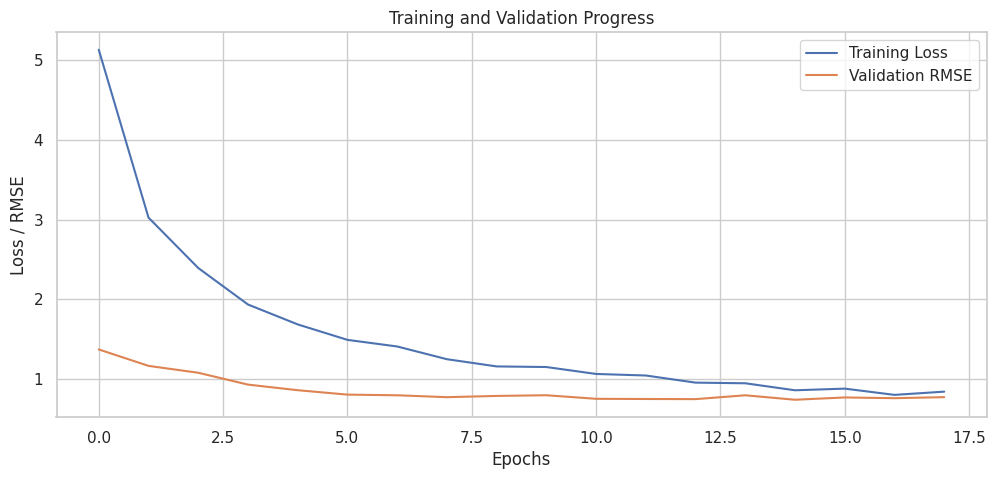


Memuat model terbaik dari: /kaggle/working/best_ncf_model_final.pth

Mengevaluasi model pada data training untuk perbandingan overfitting...


Mengevaluasi Training Set: 100%|██████████| 383/383 [02:18<00:00,  2.76it/s]



Mengevaluasi model pada test set...


Mengevaluasi Test Set: 100%|██████████| 42/42 [00:15<00:00,  2.79it/s]



--- Hasil Evaluasi Keseluruhan ---
Overall RMSE: 0.7374
Overall MAE: 0.5213

--- Hasil Evaluasi per Kelas Rating ---
⭐ Rating 1 (51 sampel):
  - RMSE: 2.1477
  - MAE: 1.6101
  - Rata-rata Prediksi: 2.61
⭐ Rating 2 (21 sampel):
  - RMSE: 1.7794
  - MAE: 1.6641
  - Rata-rata Prediksi: 3.42
⭐ Rating 3 (60 sampel):
  - RMSE: 1.1450
  - MAE: 0.9978
  - Rata-rata Prediksi: 3.88
⭐ Rating 4 (201 sampel):
  - RMSE: 0.6203
  - MAE: 0.5701
  - Rata-rata Prediksi: 4.43
⭐ Rating 5 (1011 sampel):
  - RMSE: 0.5198
  - MAE: 0.4047
  - Rata-rata Prediksi: 4.60


HASIL PERBANDINGAN EVALUASI: TRAINING SET vs. TEST SET
| Metrik   |   Training Set |   Test Set |
|:---------|---------------:|-----------:|
| RMSE     |       0.509212 |   0.737436 |
| MAE      |       0.395613 |   0.521315 |

[Visualisasi] Menampilkan distribusi prediksi per kelas rating...


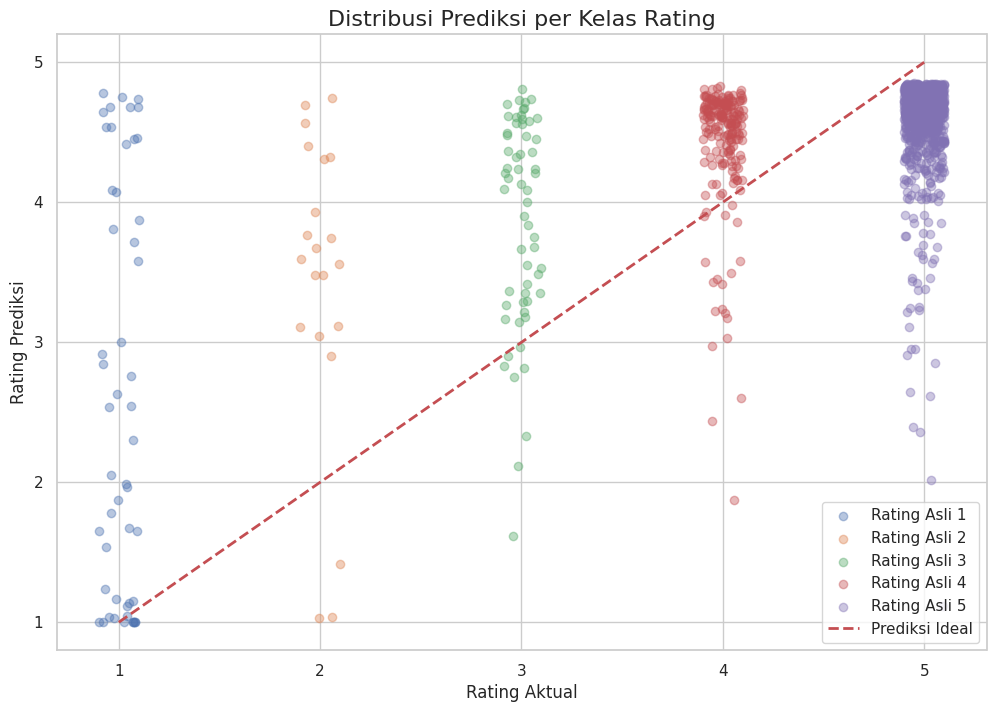


✅ Proses evaluasi selesai.


In [24]:
LOSS_CURVE_PATH = os.path.join(KAGGLE_OUTPUT_DIR, "loss_curve_improved.png")
RATING_DIST_PATH = os.path.join(KAGGLE_OUTPUT_DIR, "rating_class_distribution_improved.png")

# ==============================================================================
# 1. VISUALISASI KURVA PELATIHAN
# ==============================================================================
print("="*50)
print("7. EVALUASI MODEL SECARA MENYELURUH")
print("="*50)
print("\n[Visualisasi] Menampilkan progres training dan validasi...")

plt.figure(figsize=(12, 5))
plt.plot(train_losses, label='Training Loss')
plt.plot(val_rmses, label='Validation RMSE')
plt.xlabel('Epochs')
plt.ylabel('Loss / RMSE')
plt.title('Training and Validation Progress')
plt.legend()
plt.grid(True)
# Menyimpan plot ke path yang sudah ditentukan di /kaggle/working/
plt.savefig(LOSS_CURVE_PATH)
plt.show()

# ==============================================================================
# 2. EVALUASI MODEL TERBAIK PADA TEST SET
# ==============================================================================

# Muat state model terbaik yang sudah disimpan
print(f"\nMemuat model terbaik dari: {MODEL_SAVE_PATH}")
model = NCFModel().to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval() # Set model ke mode evaluasi

print("\nMengevaluasi model pada data training untuk perbandingan overfitting...")

# Buat DataLoader untuk data training (tanpa shuffle, untuk evaluasi)
train_eval_loader = DataLoader(
    train_dataset,
    batch_size=BATCH_SIZE,
    shuffle=False, # Tidak perlu diacak untuk evaluasi
    drop_last=True
)

train_preds = []
train_ratings = []
with torch.no_grad():
    for batch in tqdm(train_eval_loader, desc='Mengevaluasi Training Set'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        ratings_np = batch['rating'].numpy()

        predicted_ratings = model(input_ids, attention_mask, images)
        predicted_ratings_clipped = torch.clamp(predicted_ratings, 1, 5).cpu().numpy()

        train_preds.extend(predicted_ratings_clipped)
        train_ratings.extend(ratings_np)

# Hitung metrik untuk data training
train_rmse = np.sqrt(mean_squared_error(train_ratings, train_preds))
train_mae = mean_absolute_error(train_ratings, train_preds)

# Inisialisasi list untuk menyimpan hasil prediksi dan rating asli
all_preds = []
all_ratings = []
rating_groups = {i: [] for i in range(1, 6)}
rating_values_tensor = torch.arange(1, 6).float().to(device)

print("\nMengevaluasi model pada test set...")
with torch.no_grad():
    for batch in tqdm(test_loader, desc='Mengevaluasi Test Set'):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        images = batch['image'].to(device)
        ratings_np = batch['rating'].numpy()

        # Dapatkan prediksi dari model
        # logits = model(input_ids, attention_mask, images)
        # probabilities = F.softmax(logits, dim=1)

        predicted_ratings = model(input_ids, attention_mask, images)
        
        # Hitung prediksi rating sebagai nilai harapan (expected value)
        # predicted_ratings = torch.sum(probabilities * rating_values_tensor, dim=1)
        predicted_ratings_clipped = torch.clamp(predicted_ratings, 1, 5).cpu().numpy()

        # Kumpulkan hasil
        all_preds.extend(predicted_ratings_clipped)
        all_ratings.extend(ratings_np)
        for true_r, pred_r in zip(ratings_np, predicted_ratings_clipped):
            rating_groups[int(true_r)].append((true_r, pred_r))

# Hitung metrik keseluruhan (ini dari test set)
test_rmse = np.sqrt(mean_squared_error(all_ratings, all_preds))
test_mae = mean_absolute_error(all_ratings, all_preds)
# ==============================================================================
# 3. TAMPILKAN METRIK EVALUASI
# ==============================================================================

# Hitung metrik keseluruhan
overall_rmse = np.sqrt(mean_squared_error(all_ratings, all_preds))
overall_mae = mean_absolute_error(all_ratings, all_preds)

print(f"\n--- Hasil Evaluasi Keseluruhan ---")
print(f"Overall RMSE: {overall_rmse:.4f}")
print(f"Overall MAE: {overall_mae:.4f}")

# Hitung metrik per kelas rating
print("\n--- Hasil Evaluasi per Kelas Rating ---")
for rating in sorted(rating_groups.keys()):
    group = rating_groups[rating]
    if not group:
        print(f"⭐ Rating {rating}: Tidak ada sampel di test set.")
        continue
    
    true_vals, pred_vals = zip(*group)
    rmse_class = np.sqrt(mean_squared_error(true_vals, pred_vals))
    mae_class = mean_absolute_error(true_vals, pred_vals)
    
    print(f"⭐ Rating {rating} ({len(group)} sampel):")
    print(f"  - RMSE: {rmse_class:.4f}")
    print(f"  - MAE: {mae_class:.4f}")
    print(f"  - Rata-rata Prediksi: {np.mean(pred_vals):.2f}")

# ==============================================================================
# 3. TAMPILKAN METRIK EVALUASI (PERBANDINGAN)
# ==============================================================================

# Buat DataFrame untuk perbandingan yang rapi
comparison_data = {
    'Metrik': ['RMSE', 'MAE'],
    'Training Set': [train_rmse, train_mae],
    'Test Set': [test_rmse, test_mae]
}
comparison_df = pd.DataFrame(comparison_data)

print("\n\n" + "="*60)
print("HASIL PERBANDINGAN EVALUASI: TRAINING SET vs. TEST SET")
print("="*60)
print(comparison_df.to_markdown(index=False))

# ... (lanjutkan dengan kode evaluasi per kelas rating Anda jika perlu)


# ==============================================================================
# 4. VISUALISASI DISTRIBUSI PREDIKSI
# ==============================================================================
print("\n[Visualisasi] Menampilkan distribusi prediksi per kelas rating...")
plt.figure(figsize=(12, 8))
for rating in sorted(rating_groups.keys()):
    group = rating_groups[rating]
    if not group:
        continue

    true_vals, pred_vals = zip(*group)
    # Tambahkan sedikit "jitter" pada sumbu-x agar titik tidak tumpang tindih
    plt.scatter([r + random.uniform(-0.1, 0.1) for r in true_vals], pred_vals, alpha=0.4, label=f'Rating Asli {rating}')

plt.plot([1, 5], [1, 5], 'r--', linewidth=2, label='Prediksi Ideal')
plt.xlabel('Rating Aktual', fontsize=12)
plt.ylabel('Rating Prediksi', fontsize=12)
plt.title('Distribusi Prediksi per Kelas Rating', fontsize=16)
plt.xticks([1, 2, 3, 4, 5])
plt.yticks([1, 2, 3, 4, 5])
plt.legend()
plt.grid(True)
# Menyimpan plot ke path yang sudah ditentukan di /kaggle/working/
plt.savefig(RATING_DIST_PATH)
plt.show()

print("\n✅ Proses evaluasi selesai.")

# Model Inference Testing

In [26]:
SHOP_LIST_PATH = os.path.join(KAGGLE_INPUT_DIR, "list coffee shop.csv")

# ==============================================================================
# 1. MUAT MODEL TERBAIK
# ==============================================================================

print("="*50)
print("4. ANALISIS PRESKRIPTIF (DEPLOYMENT)")
print("="*50)

print(f"Memuat model terbaik dari: {MODEL_SAVE_PATH}")
model = NCFModel().to(device)
model.load_state_dict(torch.load(MODEL_SAVE_PATH))
model.eval() # Set model ke mode evaluasi
print("Model berhasil dimuat dan siap untuk memberikan rekomendasi.")


# ==============================================================================
# 2. DEFINISI FUNGSI REKOMENDASI
# ==============================================================================

def recommend_coffee_shops(user_review, shop_ids, image_base_path, model, text_tokenizer, image_transformer, top_n=3):
    """
    Memberikan rekomendasi coffee shop berdasarkan ulasan teks pengguna.
    VERSI BARU 2.0: Memastikan semua rekomendasi memiliki gambar.
    """
    cleaned_review = clean_text(user_review)
    model.eval()
    recommendations = []
    
    # Proses input teks sekali saja agar efisien
    text_encoding = text_tokenizer(
        cleaned_review, padding='max_length', truncation=True, max_length=128, return_tensors='pt'
    )
    input_ids = text_encoding['input_ids'].to(device)
    attention_mask = text_encoding['attention_mask'].to(device)

    # --- LANGKAH BARU: Filter shop_ids untuk memastikan hanya yang memiliki gambar ---
    print("Memfilter daftar coffee shop untuk memastikan hanya yang memiliki gambar...")
    shop_ids_with_images = []
    for shop_id in shop_ids:
        shop_folder = os.path.join(image_base_path, str(shop_id))
        if os.path.exists(shop_folder):
            # Cek apakah ada file gambar di dalam folder
            if any(f.lower().endswith(('jpg', 'jpeg', 'png')) for f in os.listdir(shop_folder)):
                shop_ids_with_images.append(shop_id)
    print(f"Ditemukan {len(shop_ids_with_images)} dari {len(shop_ids)} coffee shop yang memiliki gambar.")

    # --- PERUBAHAN DI SINI: Gunakan daftar yang sudah difilter untuk loop utama ---
    for shop_id in tqdm(shop_ids_with_images, desc="Memproses coffee shop"):
        shop_id_str = str(shop_id)
        shop_folder = os.path.join(image_base_path, shop_id_str)
        
        # Di titik ini, kita sudah yakin folder ada dan berisi gambar
        image_paths = [os.path.join(shop_folder, f) for f in os.listdir(shop_folder) if f.lower().endswith(('jpg', 'jpeg', 'png'))]
        
        selected_image_path = random.choice(image_paths)
        try:
            image = Image.open(selected_image_path).convert('RGB')
            image_tensor = image_transformer(image).unsqueeze(0).to(device)
        except Exception:
            # Sebagai pengaman jika gambar rusak, meskipun path-nya ada
            continue # Lewati coffee shop ini jika gambarnya error

        with torch.no_grad():
            predicted_ratings = model(input_ids, attention_mask, image_tensor)
            predicted_rating = torch.clamp(predicted_ratings, 1, 5).item()
        
        recommendations.append((shop_id, predicted_rating, selected_image_path))

    recommendations.sort(key=lambda x: x[1], reverse=True)
    return recommendations[:top_n]

def calculate_ndcg(recommendations, true_ratings_dict, k=3):
    """Menghitung skor NDCG@k untuk mengevaluasi urutan rekomendasi."""
    shop_ids = [item[0] for item in recommendations]
    pred_scores = [[item[1] for item in recommendations]]
    true_relevance = [[true_ratings_dict.get(shop_id, 0) for shop_id in shop_ids]]
    
    if not shop_ids or sum(true_relevance[0]) == 0:
        return 0.0
        
    return ndcg_score(true_relevance, pred_scores, k=k)

4. ANALISIS PRESKRIPTIF (DEPLOYMENT)
Memuat model terbaik dari: /kaggle/working/best_ncf_model_final.pth
Model berhasil dimuat dan siap untuk memberikan rekomendasi.



Memuat data pendukung untuk nama dan rating asli coffee shop...
Data pendukung berhasil dimuat.

------------------------------------------------------------
Input Pengguna #1: 'Saya suka tempat yang tenang dan tidak terlalu ramai, cocok untuk membaca buku'
Memfilter daftar coffee shop untuk memastikan hanya yang memiliki gambar...
Ditemukan 52 dari 52 coffee shop yang memiliki gambar.


Memproses coffee shop: 100%|██████████| 52/52 [00:00<00:00, 57.53it/s]



---> Rekomendasi Coffee Shop Teratas:

1. Coffee Toffee Garut (ID: CS020)
   Prediksi Rating: 4.80 | Rating Asli: 4.5

2. Historia Coffee & Eatery (ID: CS001)
   Prediksi Rating: 4.80 | Rating Asli: 5.0

3. EZPRESSO COFFEE (ID: CS035)
   Prediksi Rating: 4.79 | Rating Asli: 5.0


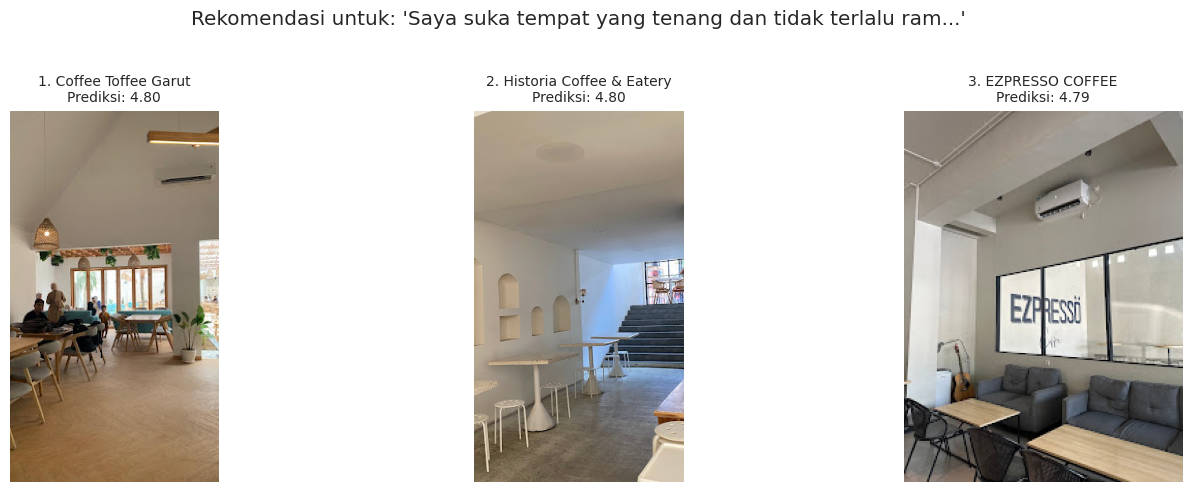

NDCG@3 untuk rekomendasi ini: 0.9760

------------------------------------------------------------
Input Pengguna #2: 'Saya menyukai tempat yang ada wifi gratis dan live musik'
Memfilter daftar coffee shop untuk memastikan hanya yang memiliki gambar...
Ditemukan 52 dari 52 coffee shop yang memiliki gambar.


Memproses coffee shop: 100%|██████████| 52/52 [00:00<00:00, 65.62it/s]



---> Rekomendasi Coffee Shop Teratas:

1. Historia Coffee & Eatery (ID: CS001)
   Prediksi Rating: 4.75 | Rating Asli: 5.0

2. WiHAUS COFFEE GARUT (ID: CS012)
   Prediksi Rating: 4.71 | Rating Asli: 4.6

3. Jemma Coffee (ID: CS009)
   Prediksi Rating: 4.71 | Rating Asli: 4.8


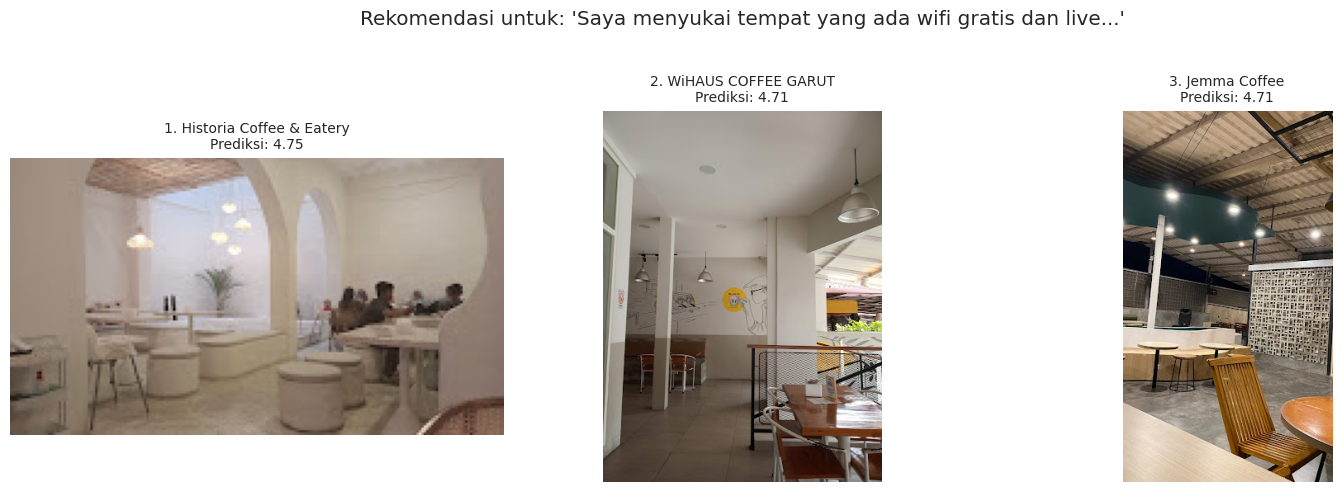

NDCG@3 untuk rekomendasi ini: 0.9975

------------------------------------------------------------
Input Pengguna #3: 'Saya ingin coffee shop dengan menu minuman yang beragam dan harga yang terjangkau'
Memfilter daftar coffee shop untuk memastikan hanya yang memiliki gambar...
Ditemukan 52 dari 52 coffee shop yang memiliki gambar.


Memproses coffee shop: 100%|██████████| 52/52 [00:00<00:00, 61.64it/s]



---> Rekomendasi Coffee Shop Teratas:

1. Historia Coffee & Eatery (ID: CS001)
   Prediksi Rating: 4.78 | Rating Asli: 5.0

2. Restorasa (ID: CS016)
   Prediksi Rating: 4.76 | Rating Asli: 4.8

3. Roti & Kopi Gudang Rasa (ID: CS017)
   Prediksi Rating: 4.75 | Rating Asli: 4.6


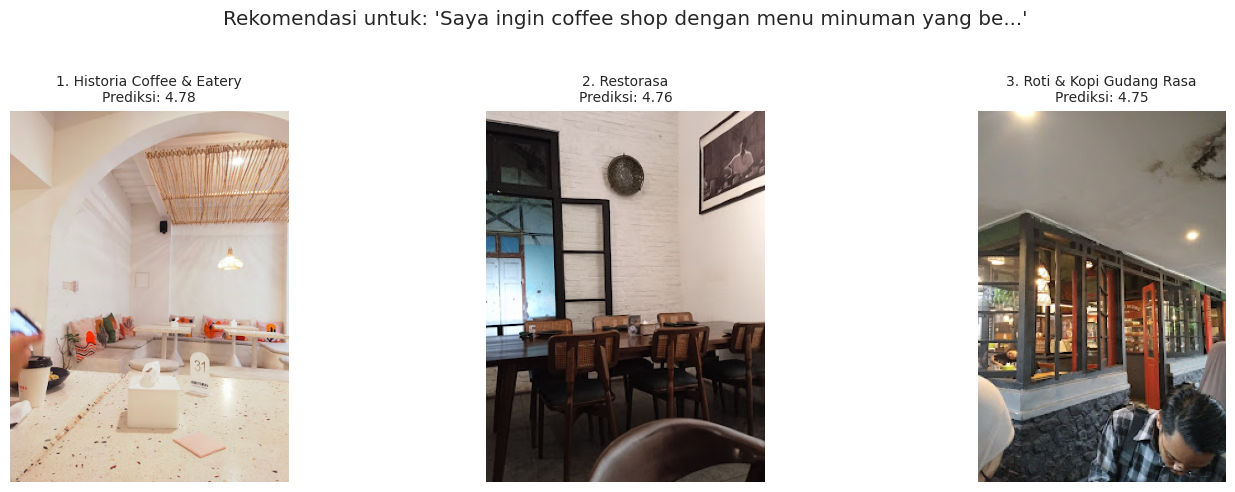

NDCG@3 untuk rekomendasi ini: 1.0000


In [27]:
# ==============================================================================
# 3. IMPLEMENTASI MULTI-REKOMENDASI
# ==============================================================================
print("\nMemuat data pendukung untuk nama dan rating asli coffee shop...")
# === PERUBAHAN UTAMA: Memuat dari path Kaggle ===
try:
    rating_df = pd.read_csv(SHOP_LIST_PATH)
    shop_titles_dict = dict(zip(rating_df['id_shop'], rating_df['title']))
    true_ratings_dict = dict(zip(rating_df['id_shop'], rating_df['totalScore']))
    all_shop_ids = reviews_df['id_shop'].unique()
    print("Data pendukung berhasil dimuat.")
except FileNotFoundError:
    print(f"ERROR: File '{SHOP_LIST_PATH}' tidak ditemukan. Proses rekomendasi dibatalkan.")
    # Hentikan eksekusi jika file penting ini tidak ada
    exit()

# Daftar input preferensi pengguna untuk diuji
user_reviews = [
    "Saya suka tempat yang tenang dan tidak terlalu ramai, cocok untuk membaca buku",
    "Saya menyukai tempat yang ada wifi gratis dan live musik",
    "Saya ingin coffee shop dengan menu minuman yang beragam dan harga yang terjangkau"
]

# Iterasi setiap input pengguna untuk mendapatkan rekomendasi
for idx, user_review in enumerate(user_reviews, 1):
    print("\n" + "-"*60)
    print(f"Input Pengguna #{idx}: '{user_review}'")

    # === PERUBAHAN UTAMA: Menggunakan path gambar yang sudah diproses di Kaggle ===
    recommendations = recommend_coffee_shops(
        user_review=user_review,
        shop_ids=all_shop_ids,
        image_base_path=PROCESSED_IMAGE_DIR,
        model=model,
        text_tokenizer=bert_tokenizer,
        image_transformer=normalization_ops,
        top_n=3
    )
    
    print("\n---> Rekomendasi Coffee Shop Teratas:")
    if not recommendations:
        print("Tidak ada rekomendasi yang bisa diberikan.")
        continue

    fig, axes = plt.subplots(1, len(recommendations), figsize=(15, 5))
    # Jika hanya ada satu rekomendasi, axes tidak akan menjadi array, jadi kita ubah
    if len(recommendations) == 1:
        axes = [axes]
    
    fig.suptitle(f"Rekomendasi untuk: '{user_review[:50]}...'")
    for i, (shop_id, score, image_path) in enumerate(recommendations):
        shop_name = shop_titles_dict.get(shop_id, f"ID {shop_id}")
        true_rating = true_ratings_dict.get(shop_id, "N/A")
        
        # Tampilkan detail teks di konsol (seperti sebelumnya)
        print(f"\n{i+1}. {shop_name} (ID: {shop_id})")
        print(f"   Prediksi Rating: {score:.2f} | Rating Asli: {true_rating}")

        # Tampilkan gambar pada subplot
        ax = axes[i]
        if image_path and os.path.exists(image_path):
            try:
                img = Image.open(image_path)
                ax.imshow(img)
                ax.set_title(f"{i+1}. {shop_name}\nPrediksi: {score:.2f}", fontsize=10)
            except Exception as e:
                ax.text(0.5, 0.5, 'Gambar Error', ha='center', va='center')
                ax.set_title(f"{i+1}. {shop_name}\n(Gambar Error)", fontsize=10)
        else:
            ax.text(0.5, 0.5, 'Tidak Ada Gambar', ha='center', va='center')
            ax.set_title(f"{i+1}. {shop_name}\n(No Image)", fontsize=10)
        
        ax.axis('off')

    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

    ndcg = calculate_ndcg(recommendations, true_ratings_dict, k=3)
    print(f"NDCG@3 untuk rekomendasi ini: {ndcg:.4f}")

# Unimodal Test


🆕 PENGUJIAN MODEL UNIMODAL (TEKS SAJA & GAMBAR SAJA)

--- Memulai pelatihan model Text Only ---


Epoch 1/10 (Text Only) | Train Loss: 3.8573 | Val Loss: 1.1954


Epoch 2/10 (Text Only) | Train Loss: 1.3481 | Val Loss: 0.9087


Epoch 3/10 (Text Only) | Train Loss: 1.2695 | Val Loss: 0.9234


Epoch 4/10 (Text Only) | Train Loss: 1.2115 | Val Loss: 0.9579


Epoch 5/10 (Text Only) | Train Loss: 1.2164 | Val Loss: 1.0006


Epoch 6/10 (Text Only) | Train Loss: 1.1991 | Val Loss: 0.9914


Epoch 7/10 (Text Only) | Train Loss: 1.1419 | Val Loss: 1.1484


Epoch 8/10 (Text Only) | Train Loss: 1.0857 | Val Loss: 1.2203


Epoch 9/10 (Text Only) | Train Loss: 1.0997 | Val Loss: 1.3003


Epoch 10/10 (Text Only) | Train Loss: 1.0724 | Val Loss: 1.2379
--- Evaluasi Akhir Text Only ---
RMSE: 1.1126, MAE: 0.8213

--- Memulai pelatihan model Image Only ---


Epoch 1/10 (Image Only) | Train Loss: 4.0305 | Val Loss: 1.3619


Epoch 2/10 (Image Only) | Train Loss: 1.4880 | Val Loss: 1.0843


Epoch 3/10 (Image Only) | Train Loss: 1.5005 | Val Loss: 1.3436


Epoch 4/10 (Image Only) | Train Loss: 1.4926 | Val Loss: 1.0551


Epoch 5/10 (Image Only) | Train Loss: 1.4384 | Val Loss: 1.2456


Epoch 6/10 (Image Only) | Train Loss: 1.4408 | Val Loss: 1.0738


Epoch 7/10 (Image Only) | Train Loss: 1.4327 | Val Loss: 1.1002


Epoch 8/10 (Image Only) | Train Loss: 1.3790 | Val Loss: 1.0978


Epoch 9/10 (Image Only) | Train Loss: 1.3871 | Val Loss: 1.0247


Epoch 10/10 (Image Only) | Train Loss: 1.3530 | Val Loss: 1.1841
--- Evaluasi Akhir Image Only ---
RMSE: 1.0881, MAE: 0.9360

--- Perbandingan Performa Model (RMSE & MAE) ---
        Model      RMSE       MAE
0  Multimodal  0.737436  0.521315
1   Text Only  1.112601  0.821314
2  Image Only  1.088150  0.935964


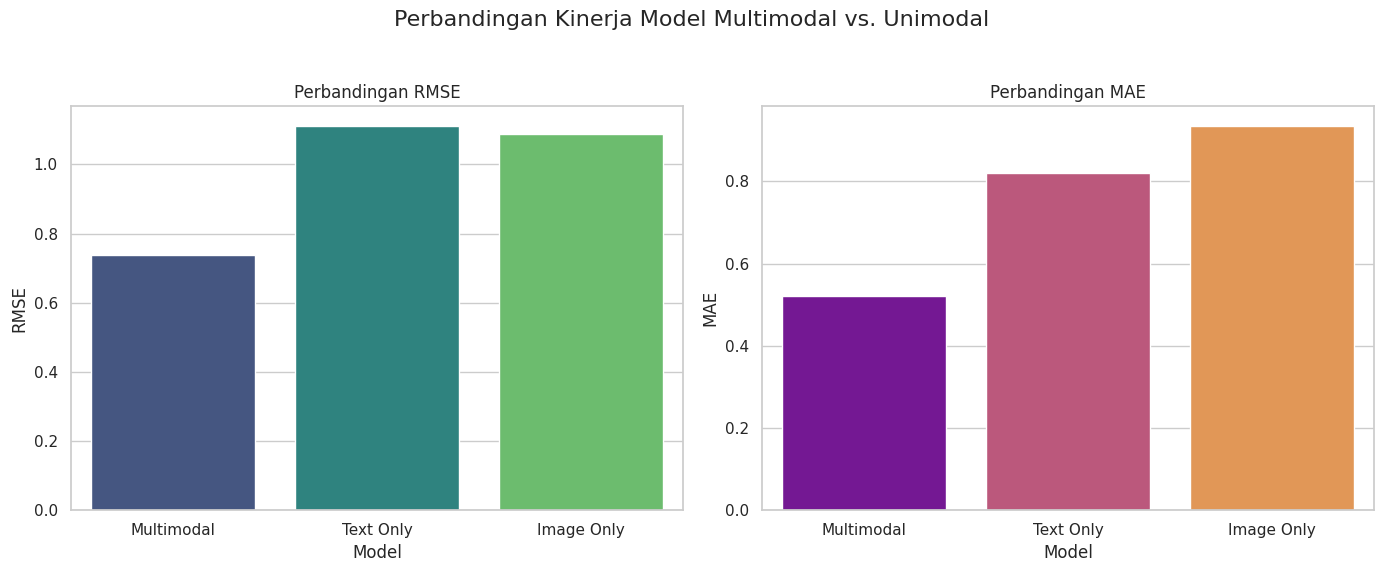

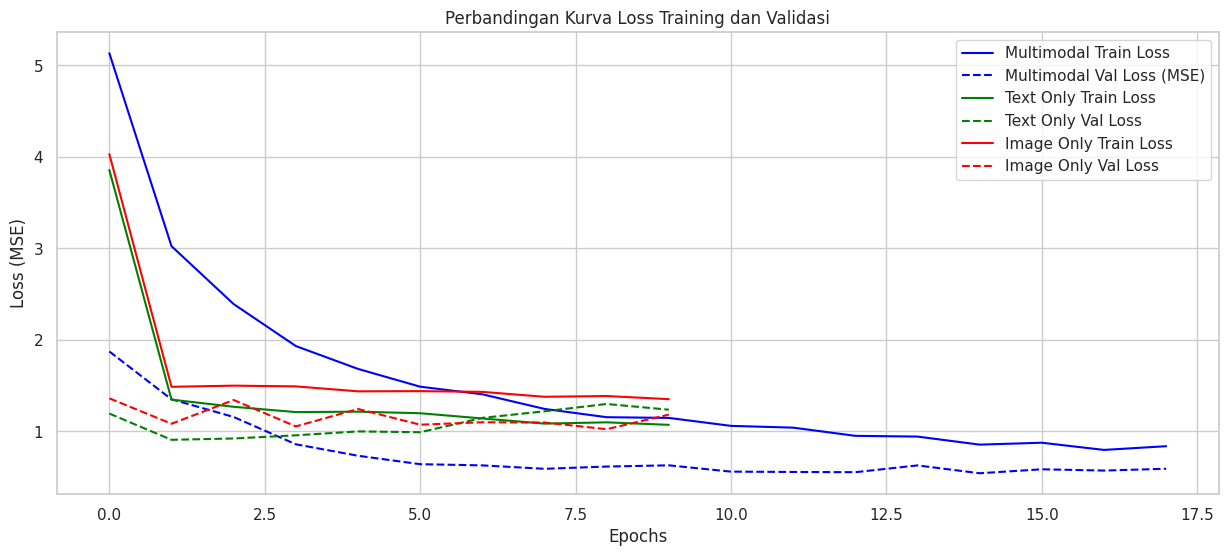


✅ Perbandingan model unimodal dengan multimodal selesai.


In [28]:
METRICS_PLOT_PATH = os.path.join(KAGGLE_OUTPUT_DIR, "unimodal_metrics_comparison.png")
LOSS_COMP_PLOT_PATH = os.path.join(KAGGLE_OUTPUT_DIR, "unimodal_loss_comparison.png")


# ==============================================================================
# 1. DEFINISI MODEL UNIMODAL (Tanpa Perubahan)
# ==============================================================================
print("\n" + "="*60)
print("🆕 PENGUJIAN MODEL UNIMODAL (TEKS SAJA & GAMBAR SAJA)")
print("="*60)

# Model Teks Saja
class TextOnlyModel(nn.Module):
    def __init__(self, text_dim=768, embed_size=64):
        super(TextOnlyModel, self).__init__()
        self.text_path = nn.Sequential(
            nn.Linear(text_dim, 256), nn.ReLU(), nn.BatchNorm1d(256), nn.Dropout(0.3),
            nn.Linear(256, embed_size)
        )
        self.output_layer = nn.Linear(embed_size, 1)

    def forward(self, text_input):
        text_repr = self.text_path(text_input)
        return self.output_layer(text_repr).squeeze()

# Model Gambar Saja
class ImageOnlyModel(nn.Module):
    def __init__(self, image_dim=512, embed_size=64):
        super(ImageOnlyModel, self).__init__()
        self.image_path = nn.Sequential(
            nn.Linear(image_dim, 128), nn.ReLU(), nn.BatchNorm1d(128), nn.Dropout(0.3),
            nn.Linear(128, embed_size)
        )
        self.output_layer = nn.Linear(embed_size, 1)

    def forward(self, image_input):
        image_repr = self.image_path(image_input)
        return self.output_layer(image_repr).squeeze()


# ==============================================================================
# 2. FUNGSI PELATIHAN UNIMODAL (Tanpa Perubahan)
# ==============================================================================
def train_and_evaluate_unimodal(model, train_loader, test_loader, epochs, model_name):
    print(f"\n--- Memulai pelatihan model {model_name} ---")
    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-5)
    scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, 'min', patience=3, factor=0.5)
    train_losses_unimodal, val_losses_unimodal = [], []

    for epoch in range(epochs):
        model.train()
        total_loss = 0
        for batch in tqdm(train_loader, desc=f'Epoch {epoch+1}/{epochs} ({model_name})', leave=False):
            input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
            images, ratings = batch['image'].to(device), batch['rating'].to(device).float()
            optimizer.zero_grad()
            
            with torch.no_grad(): # Ekstrak fitur tanpa fine-tuning
                if model_name == "Text Only":
                    inputs = bert_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
                else: # Image Only
                    inputs = torch.flatten(resnet_model(images), start_dim=1)
            
            outputs = model(inputs)
            loss = criterion(outputs, ratings)
            loss.backward()
            optimizer.step()
            total_loss += loss.item()
        
        avg_train_loss = total_loss / len(train_loader)
        train_losses_unimodal.append(avg_train_loss)

        model.eval()
        val_loss, all_preds, all_ratings = 0, [], []
        with torch.no_grad():
            for batch in test_loader:
                input_ids, attention_mask = batch['input_ids'].to(device), batch['attention_mask'].to(device)
                images, ratings = batch['image'].to(device), batch['rating'].to(device).float()
                if model_name == "Text Only":
                    inputs = bert_model(input_ids=input_ids, attention_mask=attention_mask).last_hidden_state[:, 0, :]
                else: # Image Only
                    inputs = torch.flatten(resnet_model(images), start_dim=1)
                
                outputs = model(inputs)
                val_loss += criterion(outputs, ratings).item()
                all_preds.extend(outputs.cpu().numpy().flatten().tolist())
                all_ratings.extend(ratings.cpu().numpy().flatten().tolist())
        
        avg_val_loss = val_loss / len(test_loader)
        val_losses_unimodal.append(avg_val_loss)
        scheduler.step(avg_val_loss)
        print(f"Epoch {epoch+1}/{epochs} ({model_name}) | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f}")

    rmse = np.sqrt(mean_squared_error(all_ratings, all_preds))
    mae = mean_absolute_error(all_ratings, all_preds)
    print(f"--- Evaluasi Akhir {model_name} ---")
    print(f"RMSE: {rmse:.4f}, MAE: {mae:.4f}")
    return rmse, mae, train_losses_unimodal, val_losses_unimodal


# ==============================================================================
# 3. EKSEKUSI DAN VISUALISASI PERBANDINGAN
# ==============================================================================
# Model Teks Saja
text_model = TextOnlyModel().to(device)
rmse_text, mae_text, train_losses_text, val_losses_text = train_and_evaluate_unimodal(
    text_model, train_loader, test_loader, epochs=10, model_name="Text Only"
)

# Model Gambar Saja
image_model = ImageOnlyModel().to(device)
rmse_image, mae_image, train_losses_image, val_losses_image = train_and_evaluate_unimodal(
    image_model, train_loader, test_loader, epochs=10, model_name="Image Only"
)

# --- Visualisasi Perbandingan Performa ---
print("\n--- Perbandingan Performa Model (RMSE & MAE) ---")
try:
    metrics_df = pd.DataFrame({
        'Model': ['Multimodal', 'Text Only', 'Image Only'],
        'RMSE': [overall_rmse, rmse_text, rmse_image],
        'MAE': [overall_mae, mae_text, mae_image]
    })
    print(metrics_df)

    fig, axes = plt.subplots(1, 2, figsize=(14, 6))
    fig.suptitle("Perbandingan Kinerja Model Multimodal vs. Unimodal", fontsize=16)
    sns.barplot(x='Model', y='RMSE', data=metrics_df, ax=axes[0], palette='viridis').set_title('Perbandingan RMSE')
    sns.barplot(x='Model', y='MAE', data=metrics_df, ax=axes[1], palette='plasma').set_title('Perbandingan MAE')
    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.savefig(METRICS_PLOT_PATH) # Menyimpan plot ke output Kaggle
    plt.show()

    # Visualisasi Kurva Loss
    plt.figure(figsize=(15, 6))
    # Konversi Val RMSE dari model multimodal ke MSE agar skalanya sama
    multimodal_val_mse = [v**2 for v in val_rmses]
    plt.plot(train_losses, label='Multimodal Train Loss', linestyle='-', color='blue')
    plt.plot(multimodal_val_mse, label='Multimodal Val Loss (MSE)', linestyle='--', color='blue')
    plt.plot(train_losses_text, label='Text Only Train Loss', linestyle='-', color='green')
    plt.plot(val_losses_text, label='Text Only Val Loss', linestyle='--', color='green')
    plt.plot(train_losses_image, label='Image Only Train Loss', linestyle='-', color='red')
    plt.plot(val_losses_image, label='Image Only Val Loss', linestyle='--', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Loss (MSE)')
    plt.title('Perbandingan Kurva Loss Training dan Validasi')
    plt.legend()
    plt.grid(True)
    plt.savefig(LOSS_COMP_PLOT_PATH) # Menyimpan plot ke output Kaggle
    plt.show()

except NameError:
    print("\nMelewatkan plot perbandingan karena metrik dari model multimodal tidak tersedia.")

print("\n✅ Perbandingan model unimodal dengan multimodal selesai.")